# SETUP

## Check environment

In [1]:
USE_GPU = True

In [2]:
try:
    import google.colab
    COLAB = True
except:
    COLAB = False
print(f"Using Google Colab: {COLAB}")

Using Google Colab: False


In [3]:
!pip install --upgrade pip tensorflow keras jupyterlab-vim jupyterlab-indent-guides maap-user-workspace-management-jupyter-extension pydot
!apt-get install graphviz -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  gyp javascript-common libauthen-sasl-perl libc-ares2 libclone-perl
  libdata-dump-perl libencode-locale-perl libfile-basedir-perl
  libfile-desktopentry-perl libfile-listing-perl libfile-mimeinfo-perl
  libfont-afm-perl libfontenc1 libgtkd-3-0 libhtml-form-perl
  libhtml-format-perl libhtml-parser-perl libhtml-tagset-perl
  libhtml-tree-perl libhttp-cookies-perl libhttp-daemon-perl libhttp-date-perl
  libhttp-message-perl libhttp-negotiate-perl libio-html-perl
  libio-socket-ssl-perl libio-stringy-perl libipc-system-simple-perl
  libjs-events libjs-highlight.js libjs-inherits libjs-is-typedarray libjs-psl
  libjs-source-map libjs-sprintf-js libjs-typedarray-to-buffer libllvm11
  liblwp-mediatypes-perl liblwp-protocol-https-perl libmailtools-perl
  lib

## Libraries

In [4]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging
import sys

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K

# Append the custom libraries to system path
if COLAB:
    sys.path.append("/content/air_quality_index_project")

# Configure device
if not USE_GPU:
    print("Using CPU to train")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print("Using GPU to train")

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data, plot_prediction
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import LSTMPrediction
from src.loop_model import generate_loopresults, choose_the_best
from src.time_series_utils import prepareReducedData
from src.data_utils import mice

# Configuration reader
from src.config_reader import ConfigurationReader

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

E0000 00:00:1754831784.040475 3437735 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754831784.046828 3437735 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754831784.062615 3437735 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754831784.062633 3437735 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754831784.062635 3437735 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754831784.062637 3437735 computation_placer.cc:177] computation placer already registered. Please check linka

Using GPU to train
2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Configuration

In [5]:
if COLAB:
    confReader = ConfigurationReader("/content/air_quality_index_project/model_params_colab.json")
else:
    confReader = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json")
print(confReader)

conf = confReader.data

# Clear all temp folders
def cleanDir(input_dir):
    if os.path.exists(input_dir):
        shutil.rmtree(input_dir)
    os.makedirs(input_dir)

cleanDir(conf["workspace"]["model_info_dir"])
cleanDir(conf["workspace"]["model_checkpoints_dir"])
cleanDir(conf["workspace"]["data_statistic_dir"])
cleanDir(conf["workspace"]["data_by_station_dir"])
cleanDir(conf["workspace"]["data_by_location_dir"])
cleanDir(conf["workspace"]["best_reduction_models_dir"])
cleanDir(conf["workspace"]["best_reduced_data"])

{
    "dataset": {
        "aod2022": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MatchingData2022.xlsx",
            "target_start_date": "2022-01-01",
            "target_end_date": "2022-12-31"
        },
        "aod2021": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/aod_data_daily.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2021-12-31"
        },
        "mpair": {
            "file_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MPair.csv",
            "target_start_date": "2021-01-01",
            "target_end_date": "2022-12-31",
            "station_2022_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2022.csv",
            "station_2018_2021_dir": "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2018-2021.c

# AOD DATA

## Load 2022 dataset

In [6]:
df_aod_raw_2022 = pd.read_excel(conf["dataset"]["aod2022"]["file_dir"])

print(df_aod_raw_2022.columns)
df_aod_raw_2022

Index(['time', 'ID', 'pm25', 'lat', 'lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'PRES2M', 'AOD', 'OID', 'POP', 'ROAD_DEN_1km',
       'PRIM_ROAD_LEN_1km', 'NEAR_DIST', 'BARELAND', 'BUILTUP', 'CROPLAND',
       'GRASSLAND', 'TREECOVER', 'WATER', 'NDVI', 'Name'],
      dtype='object')


time  ID       pm25        lat         lon   PM25_3km        TMP  \
0    2022-01-01  S4  23.768238  10.815839  106.717396  22.025597  28.261583   
1    2022-01-01  S5  14.221014  10.776415  106.687955  22.705284  27.787918   
2    2022-01-01  S6  21.405015  10.780482  106.659511  23.503082  27.787918   
3    2022-01-01  S7  21.695652  10.783456  106.700622  22.705284  27.787918   
4    2022-01-02  S4  22.154723  10.815839  106.717396  22.711113  25.827082   
..          ...  ..        ...        ...         ...        ...        ...   
993  2022-12-30  S6  33.091428  10.780482  106.659511  19.854403  24.979719   
994  2022-12-30  S7  40.166667  10.783456  106.700622  19.137615  24.979719   
995  2022-12-31  S4  27.879261  10.815839  106.717396  28.223820  26.630608   
996  2022-12-31  S6  28.854069  10.780482  106.659511  27.658358  25.364861   
997  2022-12-31  S7  33.958333  10.783456  106.700622  26.659830  25.364861   

            RH        HPBL      WSPD  ...  PRIM_ROAD_LEN_1km  NEAR_DIST  \
0    57.233841  721.996887  2.003031  ...        2327.256348   2.546965   
1    61.073841  659.863586  1.885687  ...        7249.776367  21.703104   
2    61.073841  659.863586  1.885687  ...        2345.868408   6.057246   
3    61.073841  659.863586  1.885687  ...        6885.987305  18.537305   
4    57.916595  619.779785  1.286289  ...        2327.256348   2.546965   
..         ...         ...       ...  ...                ...        ...   
993  64.868401  680.533081  3.893373  ...        2345.868408   6.057246   
994  64.868401  680.533081  3.893373  ...        6885.987305  18.537305   
995  55.437901  607.372803  4.217750  ...        2327.256348   2.546965   
996  62.377899  799.122803  4.161542  ...        2345.868408   6.057246   
997  62.377899  799.122803  4.161542  ...        6885.987305  18.537305   

         BARELAND      BUILTUP   CROPLAND    GRASSLAND     TREECOVER  \
0     1876.639945  841524.8595  296.31157  3753.279890   91461.50468   
1      395.082094  877872.4121    0.00000    98.770523  121487.74380   
2    10370.904960  885181.4309    0.00000  8099.182920   95807.40771   
3      296.311570  764977.7039    0.00000  1876.639945  232011.95950   
4     1876.639945  841524.8595  296.31157  3753.279890   91461.50468   
..            ...          ...        ...          ...           ...   
993  10370.904960  885181.4309    0.00000  8099.182920   95807.40771   
994    296.311570  764977.7039    0.00000  1876.639945  232011.95950   
995   1876.639945  841524.8595  296.31157  3753.279890   91461.50468   
996  10370.904960  885181.4309    0.00000  8099.182920   95807.40771   
997    296.311570  764977.7039    0.00000  1876.639945  232011.95950   

           WATER         NDVI  \
0    61731.57713  1818.661486   
1        0.00000  1721.431568   
2        0.00000  1879.344348   
3        0.00000  2700.122924   
4    61731.57713  1818.661486   
..           ...          ...   
993      0.00000  1879.344348   
994      0.00000  2700.122924   
995  61731.57713  1818.661486   
996      0.00000  1879.344348   
997      0.00000  2700.122924   

                                                  Name  
0    Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn...  
1     Tòa soạn Báo Thanh Niên - Nguyễn Đình Chiểu - Q3  
2                             MobiFone Thành Thái, Q10  
3                                               ĐSQ Mỹ  
4    Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn...  
..                                                 ...  
993                           MobiFone Thành Thái, Q10  
994                                             ĐSQ Mỹ  
995  Trường THCS Cù Chính Lan, Thanh Đa, F27, Q.Bìn...  
996                           MobiFone Thành Thái, Q10  
997                                             ĐSQ Mỹ  

[998 rows x 25 columns]

In [7]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2022 = df_aod_raw_2022.assign(time=pd.to_datetime(df_aod_raw_2022["time"]))

# Set "time" column as index
#df_aod_raw_2022.set_index("time", inplace=True)

# Lower case all column names
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={name: name.lower() for name in df_aod_raw_2022.columns})

# Rename oid to station
df_aod_raw_2022 = df_aod_raw_2022.rename(columns={"oid": "station"})

# Drop unnecessary columns
df_aod_raw_2022.drop(columns=["name", "id"], axis=1, inplace=True)

# Print
df_aod_raw_2022

time       pm25        lat         lon   pm25_3km        tmp  \
0   2022-01-01  23.768238  10.815839  106.717396  22.025597  28.261583   
1   2022-01-01  14.221014  10.776415  106.687955  22.705284  27.787918   
2   2022-01-01  21.405015  10.780482  106.659511  23.503082  27.787918   
3   2022-01-01  21.695652  10.783456  106.700622  22.705284  27.787918   
4   2022-01-02  22.154723  10.815839  106.717396  22.711113  25.827082   
..         ...        ...        ...         ...        ...        ...   
993 2022-12-30  33.091428  10.780482  106.659511  19.854403  24.979719   
994 2022-12-30  40.166667  10.783456  106.700622  19.137615  24.979719   
995 2022-12-31  27.879261  10.815839  106.717396  28.223820  26.630608   
996 2022-12-31  28.854069  10.780482  106.659511  27.658358  25.364861   
997 2022-12-31  33.958333  10.783456  106.700622  26.659830  25.364861   

            rh        hpbl      wspd         pres2m  ...  road_den_1km  \
0    57.233841  721.996887  2.003031  101227.000000  ...     22.923040   
1    61.073841  659.863586  1.885687  101204.875000  ...     23.362053   
2    61.073841  659.863586  1.885687  101204.875000  ...     33.629780   
3    61.073841  659.863586  1.885687  101204.875000  ...     27.462461   
4    57.916595  619.779785  1.286289  101201.015625  ...     22.923040   
..         ...         ...       ...            ...  ...           ...   
993  64.868401  680.533081  3.893373  101393.398438  ...     33.629780   
994  64.868401  680.533081  3.893373  101393.398438  ...     27.462461   
995  55.437901  607.372803  4.217750  101322.437500  ...     22.923040   
996  62.377899  799.122803  4.161542  101297.140625  ...     33.629780   
997  62.377899  799.122803  4.161542  101297.140625  ...     27.462461   

     prim_road_len_1km  near_dist      bareland      builtup   cropland  \
0          2327.256348   2.546965   1876.639945  841524.8595  296.31157   
1          7249.776367  21.703104    395.082094  877872.4121    0.00000   
2          2345.868408   6.057246  10370.904960  885181.4309    0.00000   
3          6885.987305  18.537305    296.311570  764977.7039    0.00000   
4          2327.256348   2.546965   1876.639945  841524.8595  296.31157   
..                 ...        ...           ...          ...        ...   
993        2345.868408   6.057246  10370.904960  885181.4309    0.00000   
994        6885.987305  18.537305    296.311570  764977.7039    0.00000   
995        2327.256348   2.546965   1876.639945  841524.8595  296.31157   
996        2345.868408   6.057246  10370.904960  885181.4309    0.00000   
997        6885.987305  18.537305    296.311570  764977.7039    0.00000   

       grassland     treecover        water         ndvi  
0    3753.279890   91461.50468  61731.57713  1818.661486  
1      98.770523  121487.74380      0.00000  1721.431568  
2    8099.182920   95807.40771      0.00000  1879.344348  
3    1876.639945  232011.95950      0.00000  2700.122924  
4    3753.279890   91461.50468  61731.57713  1818.661486  
..           ...           ...          ...          ...  
993  8099.182920   95807.40771      0.00000  1879.344348  
994  1876.639945  232011.95950      0.00000  2700.122924  
995  3753.279890   91461.50468  61731.57713  1818.661486  
996  8099.182920   95807.40771      0.00000  1879.344348  
997  1876.639945  232011.95950      0.00000  2700.122924  

[998 rows x 23 columns]

In [8]:
df_aod_raw_2022["station"].unique()

array([214, 215, 216, 201])

## Load 2021 dataset

In [9]:
df_aod_raw_2021 = pd.read_csv(conf["dataset"]["aod2021"]["file_dir"])

print(df_aod_raw_2021.columns)
df_aod_raw_2021

Index(['time', 'ID', 'pm25', 'Lat', 'Lon', 'PM25_3km', 'TMP', 'RH', 'HPBL',
       'WSPD', 'POP', 'ROAD_DEN_1km', 'PRIM_ROAD_LEN_1km', 'NEAR_DIST',
       'BARELAND', 'BUILTUP', 'CROPLAND', 'GRASSLAND', 'TREECOVER', 'WATER',
       'NDVI', 'AOD'],
      dtype='object')


time   ID       pm25        Lat         Lon   PM25_3km        TMP  \
0       1/1/2018  201  31.391304  10.783057  106.700606  34.919998  25.204139   
1       1/1/2018  202  29.615625  10.762638  106.682027  32.099998  25.100436   
2       1/2/2018  201  37.458333  10.783057  106.700606  51.830002  24.726431   
3       1/2/2018  202  36.244792  10.762638  106.682027  44.619999  24.663358   
4       1/3/2018  201  68.083333  10.783057  106.700606  38.240002  26.095087   
...          ...  ...        ...        ...         ...        ...        ...   
2886  12/31/2021  211  14.474306  10.870190  106.796200  17.930000  23.428631   
2887  12/31/2021  212  20.100752  10.740760  106.617000  20.010000  24.914532   
2888  12/31/2021  213  23.240539  10.816350  106.620500  20.700001  24.171986   
2889  12/31/2021  214  20.549839  10.815570  106.717500  21.040001  24.367620   
2890  12/31/2021  216  19.637165  10.780630  106.659300  20.840000  22.830532   

             RH        HPBL      WSPD  ...  PRIM_ROAD_LEN_1km  NEAR_DIST  \
0     70.056728  455.131335  2.352895  ...        6885.987305  18.537305   
1     71.060891  457.243423  2.344162  ...        7097.612305   3.822386   
2     73.425826  339.083720  1.903761  ...        6885.987305  18.537305   
3     73.870799  338.530190  1.885305  ...        7097.612305   3.822386   
4     77.793432  367.190738  1.293329  ...        6885.987305  18.537305   
...         ...         ...       ...  ...                ...        ...   
2886  75.209297  134.323181  1.485907  ...           0.000000  49.023548   
2887  64.741638  212.347687  2.196620  ...        2529.119629  20.331284   
2888  67.759666  145.481979  2.459679  ...           0.000000   7.560823   
2889  67.038559  168.648315  2.101351  ...        2327.256348   2.546965   
2890  79.056641  184.397690  2.316177  ...        2345.868408   6.057246   

          BARELAND      BUILTUP     CROPLAND     GRASSLAND     TREECOVER  \
0       296.311570  764977.7039     0.000000   1876.639945  232011.95950   
1       395.082094  947604.4016     0.000000   2963.115702   13926.64380   
2       296.311570  764977.7039     0.000000   1876.639945  232011.95950   
3       395.082094  947604.4016     0.000000   2963.115702   13926.64380   
4       296.311570  764977.7039     0.000000   1876.639945  232011.95950   
...            ...          ...          ...           ...           ...   
2886   1086.475758  724185.4777   592.623140  46915.998620  225888.18710   
2887  16297.136360  892984.3022  7506.559780  26470.500280   57681.98567   
2888  13136.479610  928245.3791  4247.132507  17581.153170   34964.76529   
2889   1876.639945  841524.8595   296.311570   3753.279890   91461.50468   
2890  10370.904960  885181.4309     0.000000   8099.182920   95807.40771   

             WATER         NDVI       AOD  
0         0.000000  2700.122924       NaN  
1     35063.535810  1765.098553       NaN  
2         0.000000  2700.122924  1.110117  
3     35063.535810  1765.098553  1.277641  
4         0.000000  2700.122924  1.439045  
...            ...          ...       ...  
2886      0.000000  3579.160484       NaN  
2887      0.000000  3266.283480       NaN  
2888   1481.557851  2535.126792  0.272610  
2889  61731.577130  1818.661486  0.524898  
2890      0.000000  1879.344348       NaN  

[2891 rows x 22 columns]

In [10]:
# Convert "time" columns to Pandas datetime
df_aod_raw_2021['time'] = pd.to_datetime(df_aod_raw_2021['time'])

# Set "time" column as index
#df_aod_raw_2021.set_index("time", inplace=True)

# Lower case all column names
df_aod_raw_2021.rename(columns={name: name.lower() for name in df_aod_raw_2021.columns}, inplace=True)

# Rename "id" to "station"
df_aod_raw_2021.rename(columns={'id':'station'}, inplace=True)

# Only get data in 2021
time_mask = ((df_aod_raw_2021["time"] >= conf["dataset"]["aod2021"]["target_start_date"]) & (df_aod_raw_2021["time"] <= conf["dataset"]["aod2021"]["target_end_date"]))
df_aod_raw_2021 = df_aod_raw_2021.loc[time_mask]

# Print
df_aod_raw_2021

time  station       pm25        lat         lon   pm25_3km  \
1316 2021-01-01      201  17.250000  10.783057  106.700606  38.320000   
1317 2021-01-02      201  23.000000  10.783057  106.700606  56.650002   
1318 2021-01-03      201  28.291667  10.783057  106.700606  56.900002   
1319 2021-01-04      201  28.791667  10.783057  106.700606  61.560001   
1320 2021-01-05      201  24.833333  10.783057  106.700606  69.949997   
...         ...      ...        ...        ...         ...        ...   
2886 2021-12-31      211  14.474306  10.870190  106.796200  17.930000   
2887 2021-12-31      212  20.100752  10.740760  106.617000  20.010000   
2888 2021-12-31      213  23.240539  10.816350  106.620500  20.700001   
2889 2021-12-31      214  20.549839  10.815570  106.717500  21.040001   
2890 2021-12-31      216  19.637165  10.780630  106.659300  20.840000   

            tmp         rh        hpbl      wspd  ...  prim_road_len_1km  \
1316  25.873598  60.583508  561.605774  3.548874  ...        6885.987305   
1317  25.527328  60.219109  527.248901  2.355864  ...        6885.987305   
1318  26.878422  61.481564  469.774841  1.896463  ...        6885.987305   
1319  27.771753  61.013718  615.690735  1.642178  ...        6885.987305   
1320  27.660774  61.277409  665.619263  2.859253  ...        6885.987305   
...         ...        ...         ...       ...  ...                ...   
2886  23.428631  75.209297  134.323181  1.485907  ...           0.000000   
2887  24.914532  64.741638  212.347687  2.196620  ...        2529.119629   
2888  24.171986  67.759666  145.481979  2.459679  ...           0.000000   
2889  24.367620  67.038559  168.648315  2.101351  ...        2327.256348   
2890  22.830532  79.056641  184.397690  2.316177  ...        2345.868408   

      near_dist      bareland      builtup     cropland     grassland  \
1316  18.537305    296.311570  764977.7039     0.000000   1876.639945   
1317  18.537305    296.311570  764977.7039     0.000000   1876.639945   
1318  18.537305    296.311570  764977.7039     0.000000   1876.639945   
1319  18.537305    296.311570  764977.7039     0.000000   1876.639945   
1320  18.537305    296.311570  764977.7039     0.000000   1876.639945   
...         ...           ...          ...          ...           ...   
2886  49.023548   1086.475758  724185.4777   592.623140  46915.998620   
2887  20.331284  16297.136360  892984.3022  7506.559780  26470.500280   
2888   7.560823  13136.479610  928245.3791  4247.132507  17581.153170   
2889   2.546965   1876.639945  841524.8595   296.311570   3753.279890   
2890   6.057246  10370.904960  885181.4309     0.000000   8099.182920   

         treecover         water         ndvi       aod  
1316  232011.95950      0.000000  2700.122924       NaN  
1317  232011.95950      0.000000  2700.122924       NaN  
1318  232011.95950      0.000000  2700.122924       NaN  
1319  232011.95950      0.000000  2700.122924       NaN  
1320  232011.95950      0.000000  2700.122924       NaN  
...            ...           ...          ...       ...  
2886  225888.18710      0.000000  3579.160484       NaN  
2887   57681.98567      0.000000  3266.283480       NaN  
2888   34964.76529   1481.557851  2535.126792  0.272610  
2889   91461.50468  61731.577130  1818.661486  0.524898  
2890   95807.40771      0.000000  1879.344348       NaN  

[1575 rows x 22 columns]

In [11]:
df_aod_raw_2021["station"].unique()

array([201, 211, 212, 213, 214, 215, 216])

## Merge dataset

In [12]:
# Remove "pres2m" column in 2022 because it doesn't have value in 2021
df_aod_raw_2022.drop(["pres2m"], axis=1, inplace=True)

# Start merging
df_aod_raw = pd.concat([df_aod_raw_2021, df_aod_raw_2022], axis=0)

# Sort data by "station" then "time"
df_aod_raw.sort_values(by=["station", "time"], ascending=[True, True], inplace=True)

# Set index
df_aod_raw.set_index("time", inplace=True)

# Print
df_aod_raw

station       pm25        lat         lon   pm25_3km        tmp  \
time                                                                          
2021-01-01      201  17.250000  10.783057  106.700606  38.320000  25.873598   
2021-01-02      201  23.000000  10.783057  106.700606  56.650002  25.527328   
2021-01-03      201  28.291667  10.783057  106.700606  56.900002  26.878422   
2021-01-04      201  28.791667  10.783057  106.700606  61.560001  27.771753   
2021-01-05      201  24.833333  10.783057  106.700606  69.949997  27.660774   
...             ...        ...        ...         ...        ...        ...   
2022-12-27      216  39.659816  10.780482  106.659511  34.439411  24.136936   
2022-12-28      216  44.679352  10.780482  106.659511  29.838476  25.844296   
2022-12-29      216  30.724708  10.780482  106.659511  28.450829  25.841156   
2022-12-30      216  33.091428  10.780482  106.659511  19.854403  24.979719   
2022-12-31      216  28.854069  10.780482  106.659511  27.658358  25.364861   

                   rh        hpbl      wspd          pop  ...  \
time                                                      ...   
2021-01-01  60.583508  561.605774  3.548874  20680.62695  ...   
2021-01-02  60.219109  527.248901  2.355864  20680.62695  ...   
2021-01-03  61.481564  469.774841  1.896463  20680.62695  ...   
2021-01-04  61.013718  615.690735  1.642178  20680.62695  ...   
2021-01-05  61.277409  665.619263  2.859253  20680.62695  ...   
...               ...         ...       ...          ...  ...   
2022-12-27  73.973083  457.798645  2.002987  57523.91406  ...   
2022-12-28  65.530487  644.974548  2.298220  57523.91406  ...   
2022-12-29  67.093735  825.517395  2.823764  57523.91406  ...   
2022-12-30  64.868401  680.533081  3.893373  57523.91406  ...   
2022-12-31  62.377899  799.122803  4.161542  57523.91406  ...   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2021-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi       aod  
time                                                                 
2021-01-01  1876.639945  232011.95950    0.0  2700.122924       NaN  
2021-01-02  1876.639945  232011.95950    0.0  2700.122924       NaN  
2021-01-03  1876.639945  232011.95950    0.0  2700.122924       NaN  
2021-01-04  1876.639945  232011.95950    0.0  2700.122924       NaN  
2021-01-05  1876.639945  232011.95950    0.0  2700.122924       NaN  
...                 ...           ...    ...          ...       ...  
2022-12-27  8099.182920   95807.40771    0.0  1879.344348       NaN  
2022-12-28  8099.182920   95807.40771    0.0  1879.344348       NaN  
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  0.191691  
2022-12-30  8099.182920   95807.40771    0.0  1879.344348       NaN  
2022-12-31  8099.182920   95807.40771    0.0  1879.344348       NaN  

[2573 rows x 21 columns]

In [13]:
df_aod_raw.to_csv('df_aod_raw.csv', index=True)

## Statistics

In [14]:
df_aod_stat = df_aod_raw.describe()
df_aod_stat.to_csv(f'{conf["workspace"]["data_statistic_dir"]}/df_aod_stat.csv')

In [15]:
df_aod_raw.isnull().sum()

station                 0
pm25                    0
lat                     0
lon                     0
pm25_3km                0
tmp                     0
rh                      0
hpbl                    0
wspd                    0
pop                     0
road_den_1km            0
prim_road_len_1km       0
near_dist               0
bareland                0
builtup                 0
cropland                0
grassland               0
treecover               0
water                   0
ndvi                    0
aod                  2201
dtype: int64

## Preprocessing

### Define label, static features and dynamic features

In [16]:
aod_label = ["pm25"]
aod_index = ["time"]
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', \
                  'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = list(set(df_aod_raw.columns) - set(aod_stat_feats) - set(aod_label) - set(aod_index))
aod_all_stations = sorted(df_aod_raw["station"].unique())

print(f'aod_label = {aod_label}\naod_stat_feats = {aod_stat_feats}\naod_dyn_feats = {aod_dyn_feats}\naod_all_stations = {aod_all_stations}')

aod_label = ['pm25']
aod_stat_feats = ['lat', 'lon', 'station', 'pop', 'road_den_1km', 'prim_road_len_1km', 'near_dist', 'bareland', 'builtup', 'cropland', 'grassland', 'treecover', 'water', 'ndvi']
aod_dyn_feats = ['hpbl', 'aod', 'tmp', 'pm25_3km', 'wspd', 'rh']
aod_all_stations = [201, 211, 212, 213, 214, 215, 216]


### Fill "aod" column


Handling for station 201



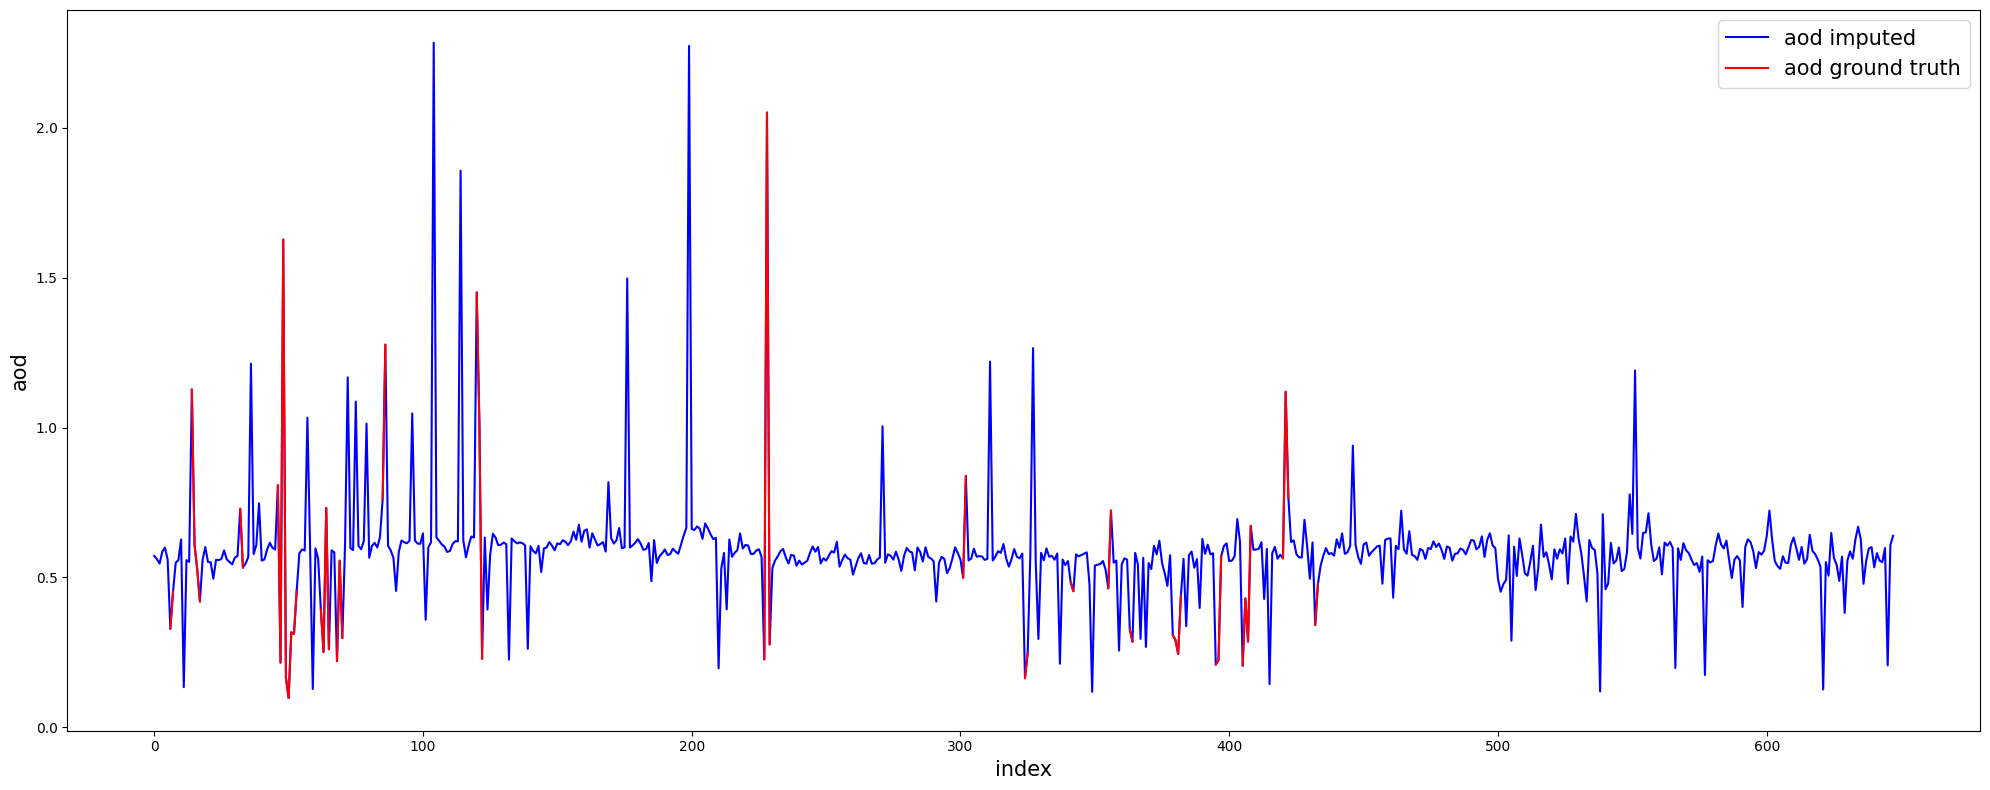


Handling for station 211



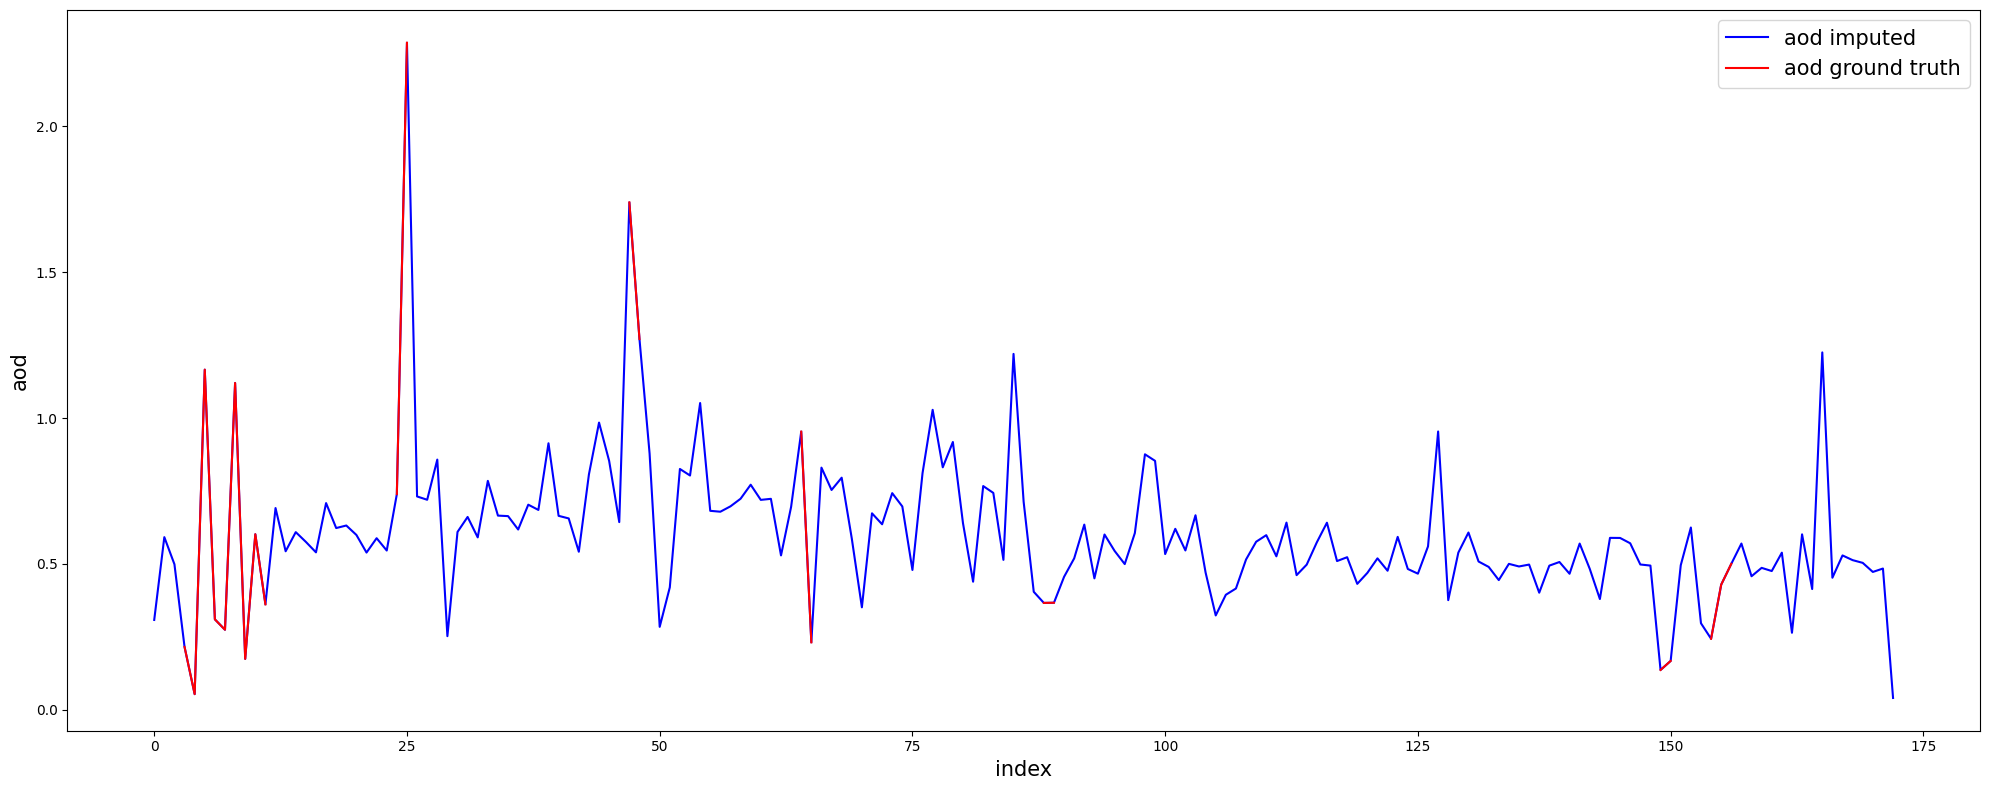


Handling for station 212



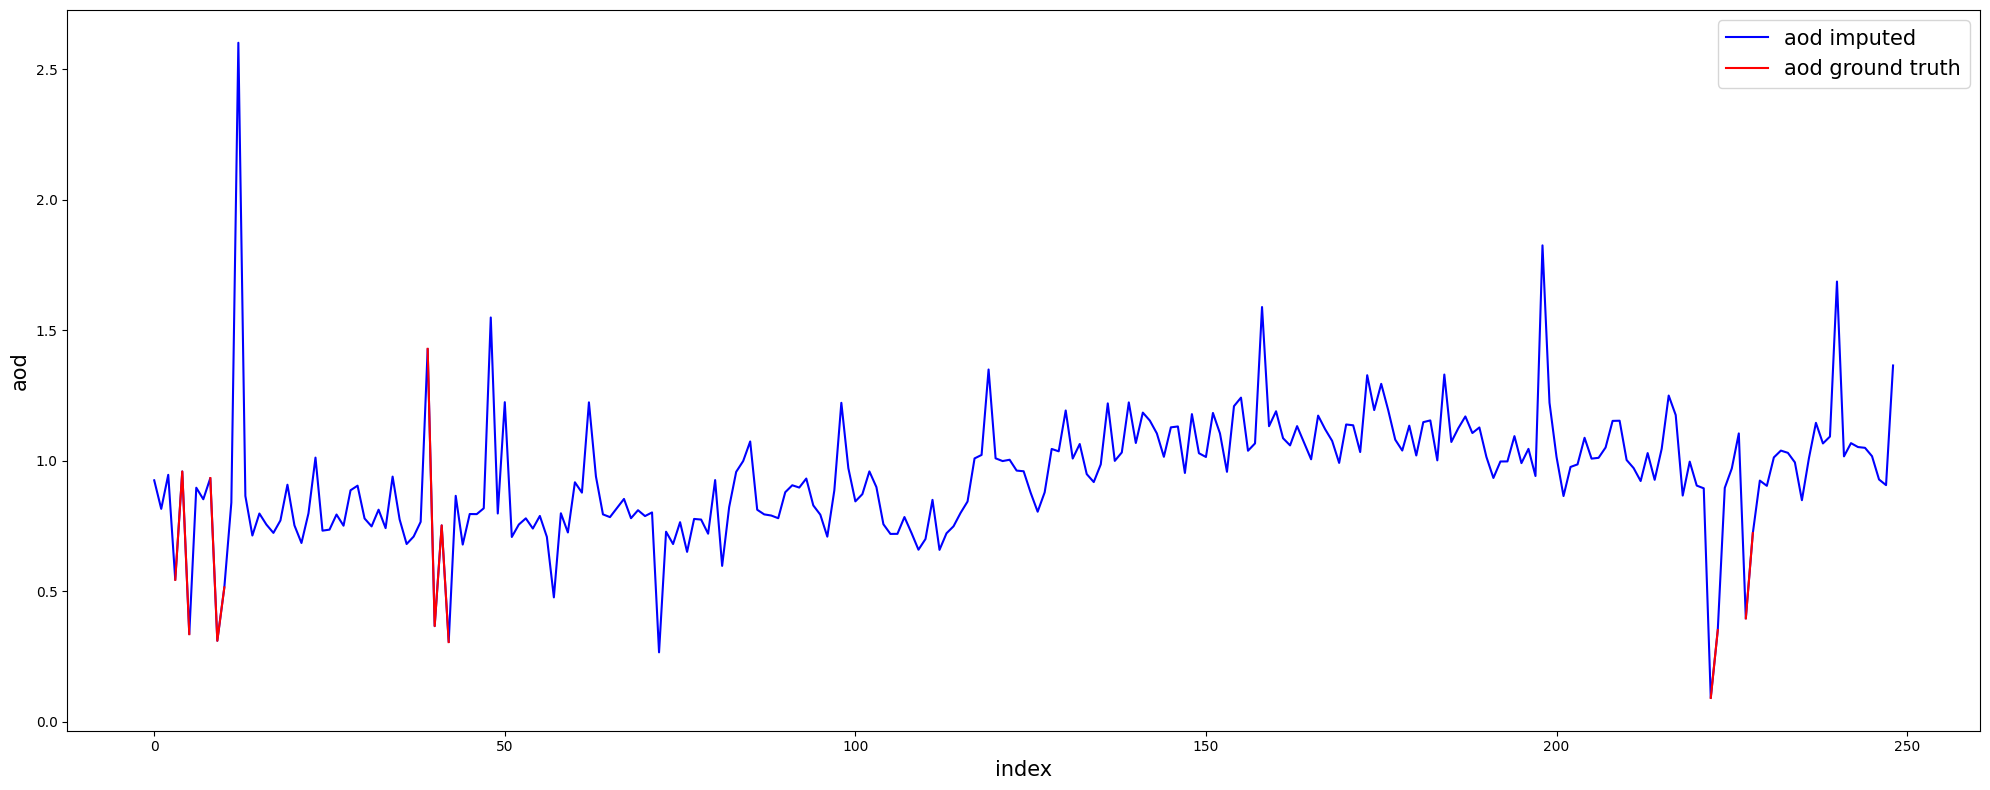


Handling for station 213



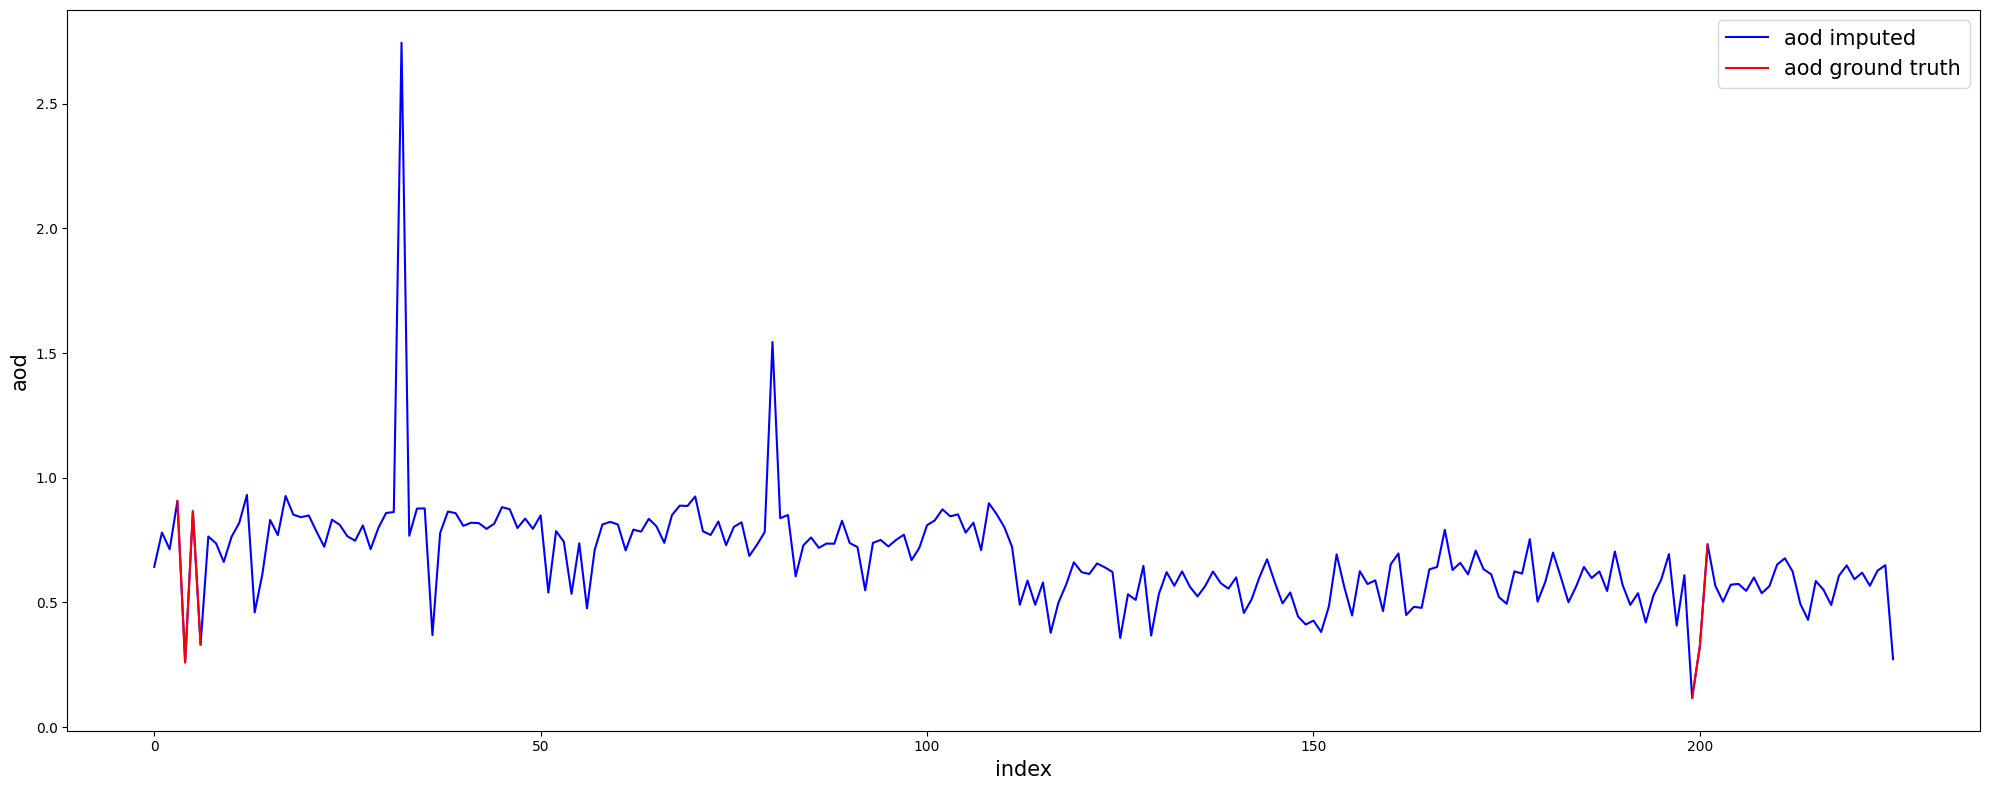


Handling for station 214



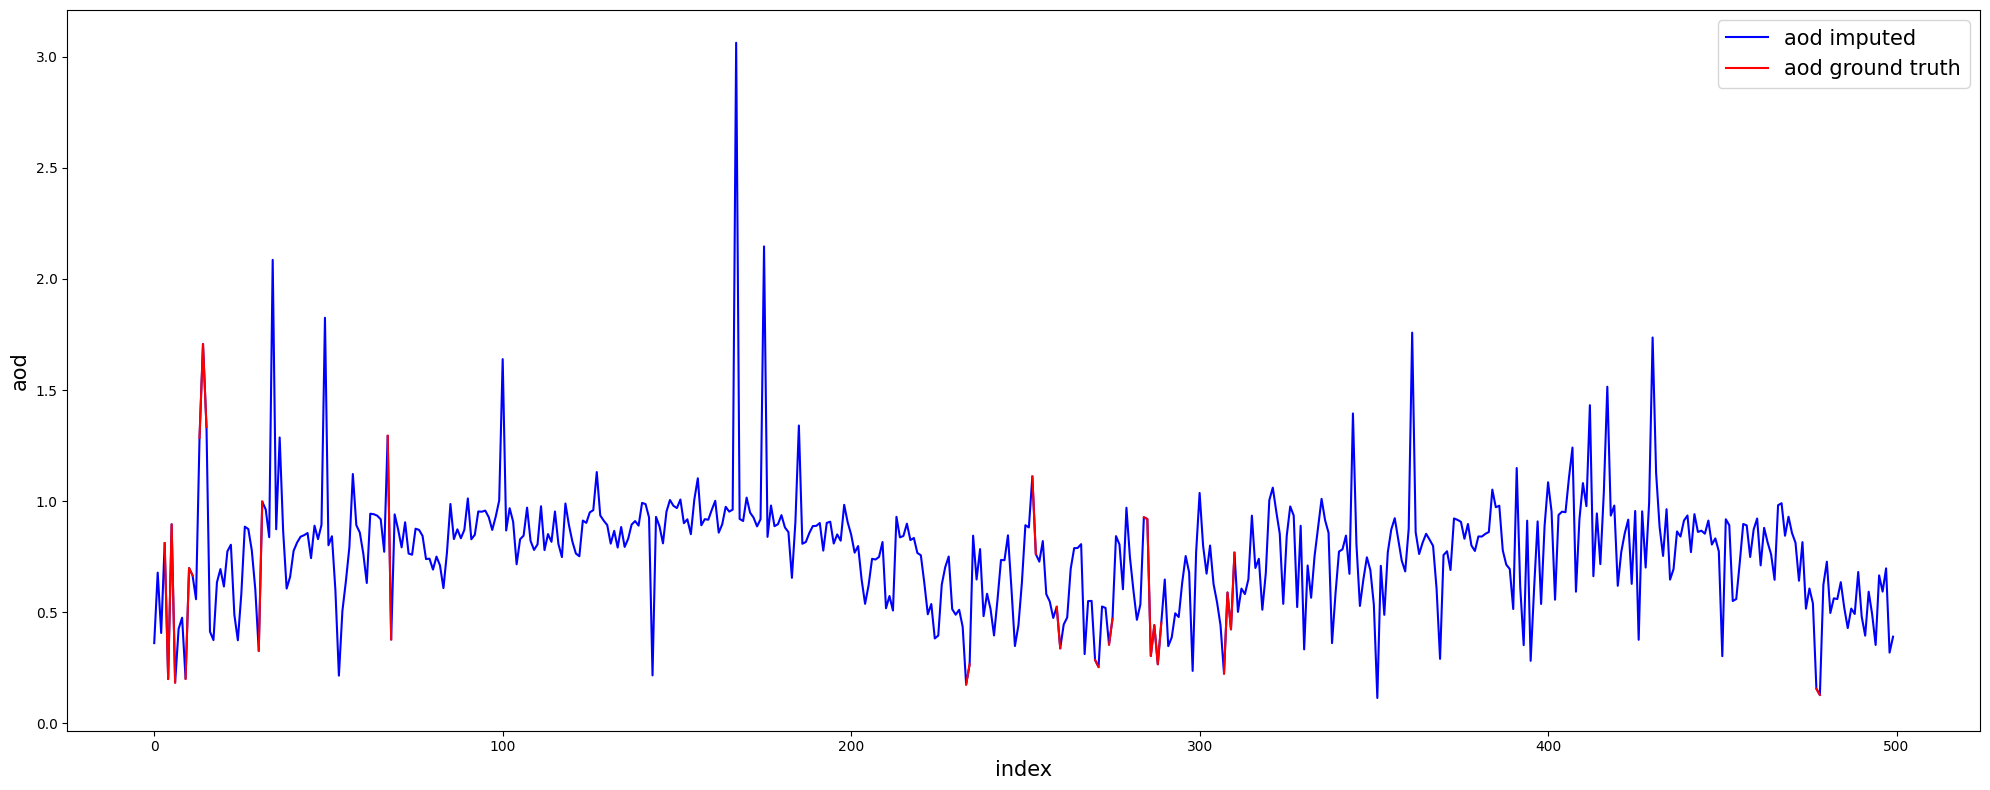


Handling for station 215



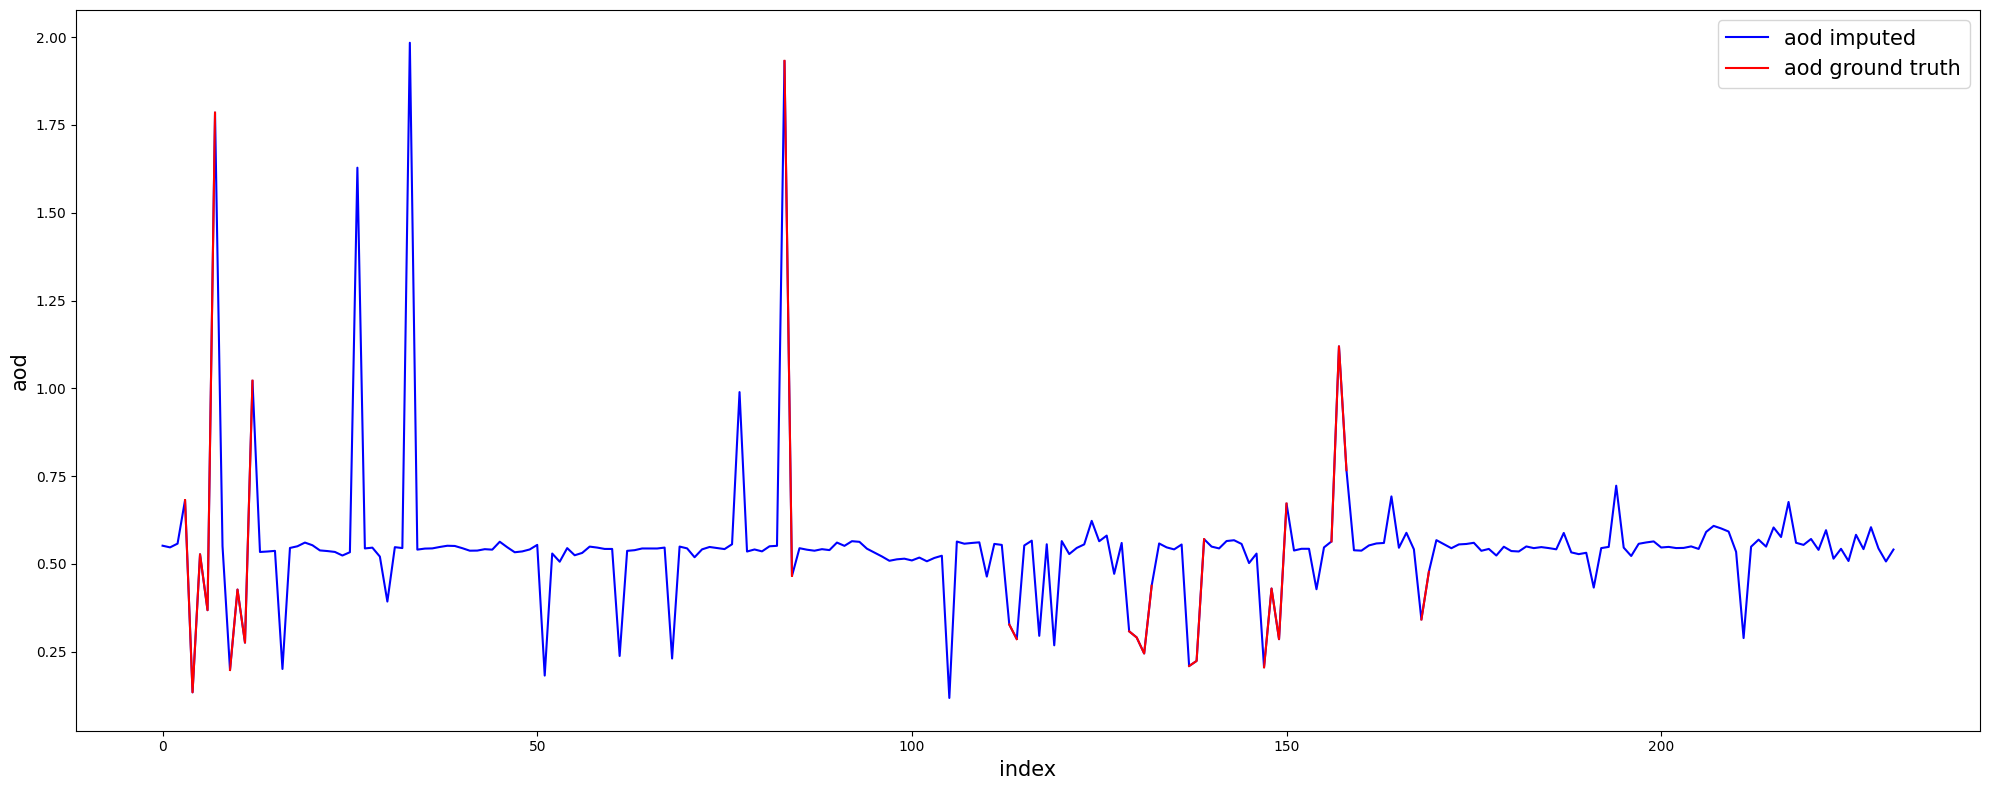


Handling for station 216



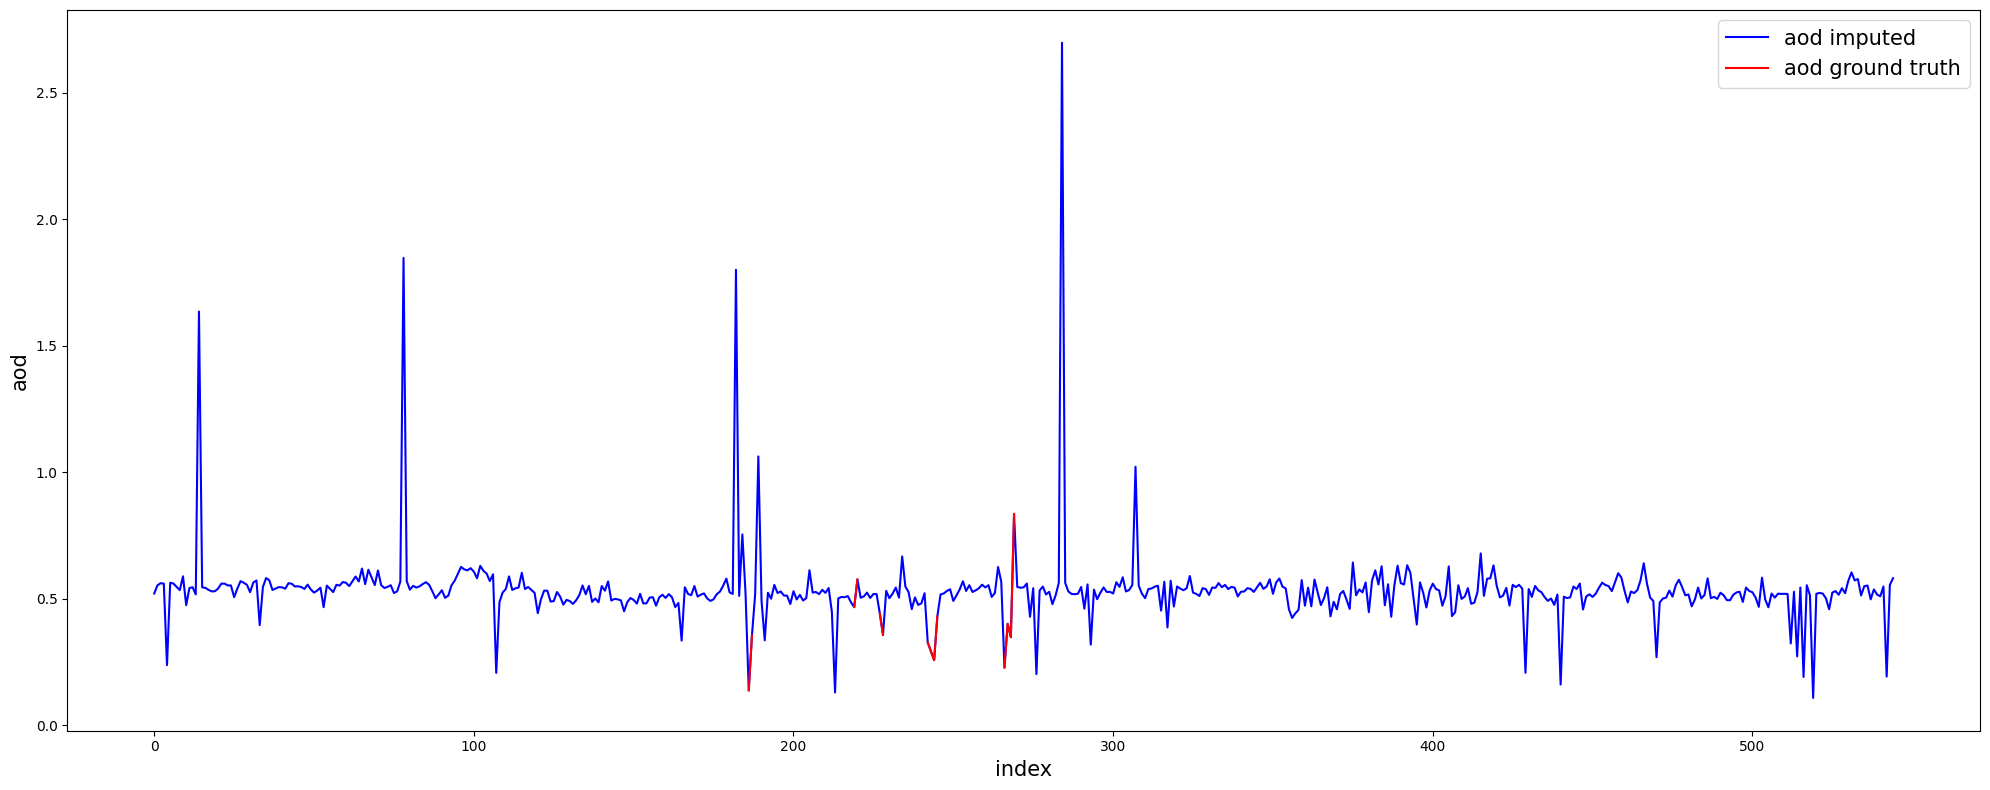

station       pm25        lat         lon   pm25_3km        tmp  \
time                                                                          
2021-01-01      201  17.250000  10.783057  106.700606  38.320000  25.873598   
2021-01-02      201  23.000000  10.783057  106.700606  56.650002  25.527328   
2021-01-03      201  28.291667  10.783057  106.700606  56.900002  26.878422   
2021-01-04      201  28.791667  10.783057  106.700606  61.560001  27.771753   
2021-01-05      201  24.833333  10.783057  106.700606  69.949997  27.660774   
...             ...        ...        ...         ...        ...        ...   
2022-12-27      216  39.659816  10.780482  106.659511  34.439411  24.136936   
2022-12-28      216  44.679352  10.780482  106.659511  29.838476  25.844296   
2022-12-29      216  30.724708  10.780482  106.659511  28.450829  25.841156   
2022-12-30      216  33.091428  10.780482  106.659511  19.854403  24.979719   
2022-12-31      216  28.854069  10.780482  106.659511  27.658358  25.364861   

                   rh        hpbl      wspd          pop  ...  \
time                                                      ...   
2021-01-01  60.583508  561.605774  3.548874  20680.62695  ...   
2021-01-02  60.219109  527.248901  2.355864  20680.62695  ...   
2021-01-03  61.481564  469.774841  1.896463  20680.62695  ...   
2021-01-04  61.013718  615.690735  1.642178  20680.62695  ...   
2021-01-05  61.277409  665.619263  2.859253  20680.62695  ...   
...               ...         ...       ...          ...  ...   
2022-12-27  73.973083  457.798645  2.002987  57523.91406  ...   
2022-12-28  65.530487  644.974548  2.298220  57523.91406  ...   
2022-12-29  67.093735  825.517395  2.823764  57523.91406  ...   
2022-12-30  64.868401  680.533081  3.893373  57523.91406  ...   
2022-12-31  62.377899  799.122803  4.161542  57523.91406  ...   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2021-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi       aod  
time                                                                 
2021-01-01  1876.639945  232011.95950    0.0  2700.122924  0.571852  
2021-01-02  1876.639945  232011.95950    0.0  2700.122924  0.561221  
2021-01-03  1876.639945  232011.95950    0.0  2700.122924  0.546221  
2021-01-04  1876.639945  232011.95950    0.0  2700.122924  0.586047  
2021-01-05  1876.639945  232011.95950    0.0  2700.122924  0.599603  
...                 ...           ...    ...          ...       ...  
2022-12-27  8099.182920   95807.40771    0.0  1879.344348  0.508564  
2022-12-28  8099.182920   95807.40771    0.0  1879.344348  0.547594  
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  0.191691  
2022-12-30  8099.182920   95807.40771    0.0  1879.344348  0.554055  
2022-12-31  8099.182920   95807.40771    0.0  1879.344348  0.580505  

[2573 rows x 21 columns]

In [17]:
all_stations_df = []

for station in aod_all_stations:
    print(f"\nHandling for station {station}\n")
    # Get dataframe of current station
    df_aod_current_station = df_aod_raw[df_aod_raw["station"] == station]
    
    # Fill "aod" column
    #df_aod_current_station.loc[:, "aod"] = df_aod_current_station.loc[:, "aod"].fillna(df_aod_current_station.loc[:, "aod"].mean())
    df_aod_current_station_imputed = copy.deepcopy(df_aod_current_station)
    df_aod_current_station_imputed.loc[:, "aod"] = mice(df_aod_current_station_imputed.drop(columns=["station", "pm25"]))["aod"]
    plot_2_data(data1=df_aod_current_station_imputed["aod"],
               datalabel1="aod imputed",
               data2=df_aod_current_station["aod"],
               datalabel2="aod ground truth",
               ylabel="aod",
               xlabel="index")

    # Store file for debugging after filling missing values
    df_aod_current_station_imputed.to_csv(f"{conf['workspace']['data_by_station_dir']}/df_aod_{station}.csv", index=True)

    # Reappend the location to dataset
    all_stations_df.append(df_aod_current_station_imputed)

# Merge all stations
df_aod = pd.concat(all_stations_df)
df_aod

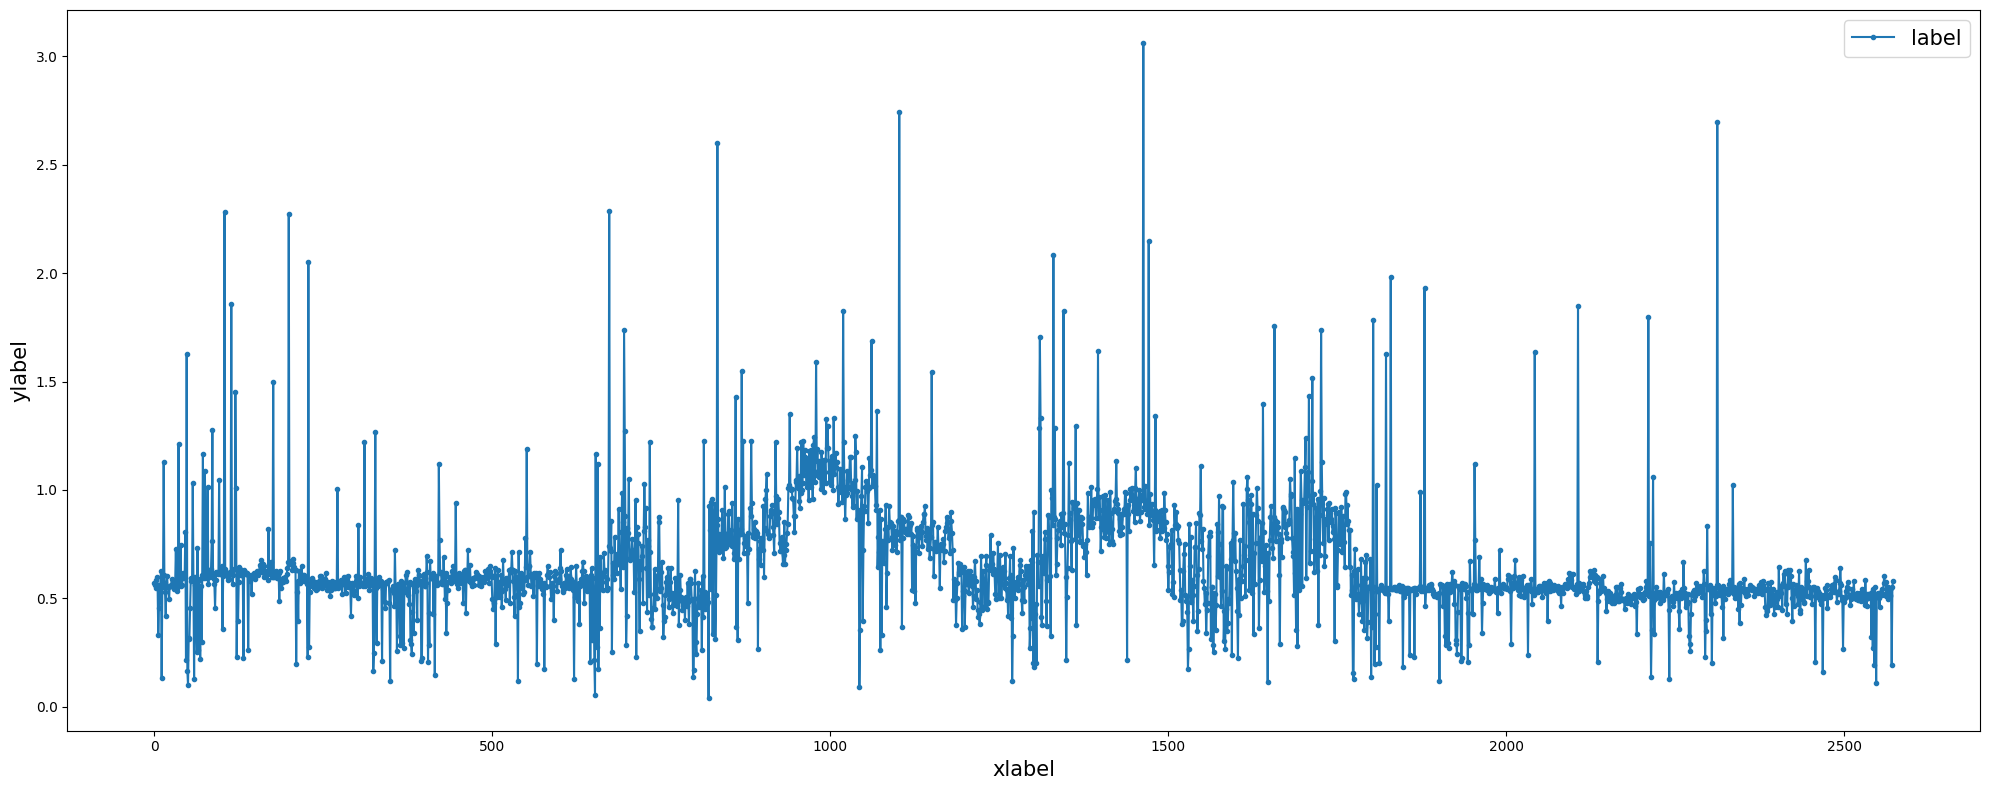

In [18]:
plot_1_data(df_aod["aod"])

In [19]:
df_aod.to_csv('df_aod.csv', index=True)

### Extract columns: time, stations

In [20]:
# Get the time indices
aod_time_indices = df_aod.index
aod_time_indices

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='time', length=2573, freq=None)

In [21]:
# Get the station column
aod_station_column = df_aod.loc[:, "station"]
aod_station_column

time
2021-01-01    201
2021-01-02    201
2021-01-03    201
2021-01-04    201
2021-01-05    201
             ... 
2022-12-27    216
2022-12-28    216
2022-12-29    216
2022-12-30    216
2022-12-31    216
Name: station, Length: 2573, dtype: int64

### Split into features and labels
* Label: pm25
* Features: other columns
    * Dynamic features
    * Static features

In [22]:
# Features with pm25_3km
aod_feats = aod_stat_feats + aod_dyn_feats
# Predict without "station" as a feature
aod_feats.remove("station")
X_aod = df_aod.loc[:, aod_feats]

# Features without pm25_3km
aod_feats.remove("pm25_3km")
X_aod_no_pm25_3km = df_aod.loc[:, aod_feats]

# Label
y_aod = df_aod.loc[:, aod_label]

In [23]:
X_aod

lat         lon          pop  road_den_1km  \
time                                                           
2021-01-01  10.783057  106.700606  20680.62695     27.462461   
2021-01-02  10.783057  106.700606  20680.62695     27.462461   
2021-01-03  10.783057  106.700606  20680.62695     27.462461   
2021-01-04  10.783057  106.700606  20680.62695     27.462461   
2021-01-05  10.783057  106.700606  20680.62695     27.462461   
...               ...         ...          ...           ...   
2022-12-27  10.780482  106.659511  57523.91406     33.629780   
2022-12-28  10.780482  106.659511  57523.91406     33.629780   
2022-12-29  10.780482  106.659511  57523.91406     33.629780   
2022-12-30  10.780482  106.659511  57523.91406     33.629780   
2022-12-31  10.780482  106.659511  57523.91406     33.629780   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2021-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi        hpbl  \
time                                                                    
2021-01-01  1876.639945  232011.95950    0.0  2700.122924  561.605774   
2021-01-02  1876.639945  232011.95950    0.0  2700.122924  527.248901   
2021-01-03  1876.639945  232011.95950    0.0  2700.122924  469.774841   
2021-01-04  1876.639945  232011.95950    0.0  2700.122924  615.690735   
2021-01-05  1876.639945  232011.95950    0.0  2700.122924  665.619263   
...                 ...           ...    ...          ...         ...   
2022-12-27  8099.182920   95807.40771    0.0  1879.344348  457.798645   
2022-12-28  8099.182920   95807.40771    0.0  1879.344348  644.974548   
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  825.517395   
2022-12-30  8099.182920   95807.40771    0.0  1879.344348  680.533081   
2022-12-31  8099.182920   95807.40771    0.0  1879.344348  799.122803   

                 aod        tmp   pm25_3km      wspd         rh  
time                                                             
2021-01-01  0.571852  25.873598  38.320000  3.548874  60.583508  
2021-01-02  0.561221  25.527328  56.650002  2.355864  60.219109  
2021-01-03  0.546221  26.878422  56.900002  1.896463  61.481564  
2021-01-04  0.586047  27.771753  61.560001  1.642178  61.013718  
2021-01-05  0.599603  27.660774  69.949997  2.859253  61.277409  
...              ...        ...        ...       ...        ...  
2022-12-27  0.508564  24.136936  34.439411  2.002987  73.973083  
2022-12-28  0.547594  25.844296  29.838476  2.298220  65.530487  
2022-12-29  0.191691  25.841156  28.450829  2.823764  67.093735  
2022-12-30  0.554055  24.979719  19.854403  3.893373  64.868401  
2022-12-31  0.580505  25.364861  27.658358  4.161542  62.377899  

[2573 rows x 19 columns]

In [24]:
X_aod_no_pm25_3km

lat         lon          pop  road_den_1km  \
time                                                           
2021-01-01  10.783057  106.700606  20680.62695     27.462461   
2021-01-02  10.783057  106.700606  20680.62695     27.462461   
2021-01-03  10.783057  106.700606  20680.62695     27.462461   
2021-01-04  10.783057  106.700606  20680.62695     27.462461   
2021-01-05  10.783057  106.700606  20680.62695     27.462461   
...               ...         ...          ...           ...   
2022-12-27  10.780482  106.659511  57523.91406     33.629780   
2022-12-28  10.780482  106.659511  57523.91406     33.629780   
2022-12-29  10.780482  106.659511  57523.91406     33.629780   
2022-12-30  10.780482  106.659511  57523.91406     33.629780   
2022-12-31  10.780482  106.659511  57523.91406     33.629780   

            prim_road_len_1km  near_dist     bareland      builtup  cropland  \
time                                                                           
2021-01-01        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-02        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-03        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-04        6885.987305  18.537305    296.31157  764977.7039       0.0   
2021-01-05        6885.987305  18.537305    296.31157  764977.7039       0.0   
...                       ...        ...          ...          ...       ...   
2022-12-27        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-28        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-29        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-30        2345.868408   6.057246  10370.90496  885181.4309       0.0   
2022-12-31        2345.868408   6.057246  10370.90496  885181.4309       0.0   

              grassland     treecover  water         ndvi        hpbl  \
time                                                                    
2021-01-01  1876.639945  232011.95950    0.0  2700.122924  561.605774   
2021-01-02  1876.639945  232011.95950    0.0  2700.122924  527.248901   
2021-01-03  1876.639945  232011.95950    0.0  2700.122924  469.774841   
2021-01-04  1876.639945  232011.95950    0.0  2700.122924  615.690735   
2021-01-05  1876.639945  232011.95950    0.0  2700.122924  665.619263   
...                 ...           ...    ...          ...         ...   
2022-12-27  8099.182920   95807.40771    0.0  1879.344348  457.798645   
2022-12-28  8099.182920   95807.40771    0.0  1879.344348  644.974548   
2022-12-29  8099.182920   95807.40771    0.0  1879.344348  825.517395   
2022-12-30  8099.182920   95807.40771    0.0  1879.344348  680.533081   
2022-12-31  8099.182920   95807.40771    0.0  1879.344348  799.122803   

                 aod        tmp      wspd         rh  
time                                                  
2021-01-01  0.571852  25.873598  3.548874  60.583508  
2021-01-02  0.561221  25.527328  2.355864  60.219109  
2021-01-03  0.546221  26.878422  1.896463  61.481564  
2021-01-04  0.586047  27.771753  1.642178  61.013718  
2021-01-05  0.599603  27.660774  2.859253  61.277409  
...              ...        ...       ...        ...  
2022-12-27  0.508564  24.136936  2.002987  73.973083  
2022-12-28  0.547594  25.844296  2.298220  65.530487  
2022-12-29  0.191691  25.841156  2.823764  67.093735  
2022-12-30  0.554055  24.979719  3.893373  64.868401  
2022-12-31  0.580505  25.364861  4.161542  62.377899  

[2573 rows x 18 columns]

In [25]:
y_aod

pm25
time                 
2021-01-01  17.250000
2021-01-02  23.000000
2021-01-03  28.291667
2021-01-04  28.791667
2021-01-05  24.833333
...               ...
2022-12-27  39.659816
2022-12-28  44.679352
2022-12-29  30.724708
2022-12-30  33.091428
2022-12-31  28.854069

[2573 rows x 1 columns]

### Data normalization

In [26]:
# Scaled features
aod_features_scaler = MinMaxScaler()
X_aod_scaled = aod_features_scaler.fit_transform(X_aod)
X_aod_scaled = pd.DataFrame(X_aod_scaled, columns=X_aod.columns)
X_aod_scaled

lat       lon      pop  road_den_1km  prim_road_len_1km  near_dist  \
0     0.326794  0.466551  0.13589      0.599996           0.949821   0.344052   
1     0.326794  0.466551  0.13589      0.599996           0.949821   0.344052   
2     0.326794  0.466551  0.13589      0.599996           0.949821   0.344052   
3     0.326794  0.466551  0.13589      0.599996           0.949821   0.344052   
4     0.326794  0.466551  0.13589      0.599996           0.949821   0.344052   
...        ...       ...      ...           ...                ...        ...   
2568  0.306899  0.237227  1.00000      1.000000           0.323578   0.075528   
2569  0.306899  0.237227  1.00000      1.000000           0.323578   0.075528   
2570  0.306899  0.237227  1.00000      1.000000           0.323578   0.075528   
2571  0.306899  0.237227  1.00000      1.000000           0.323578   0.075528   
2572  0.306899  0.237227  1.00000      1.000000           0.323578   0.075528   

      bareland   builtup  cropland  grassland  treecover  water      ndvi  \
0      0.00000  0.199903       0.0   0.037975   1.000000    0.0  0.526821   
1      0.00000  0.199903       0.0   0.037975   1.000000    0.0  0.526821   
2      0.00000  0.199903       0.0   0.037975   1.000000    0.0  0.526821   
3      0.00000  0.199903       0.0   0.037975   1.000000    0.0  0.526821   
4      0.00000  0.199903       0.0   0.037975   1.000000    0.0  0.526821   
...        ...       ...       ...        ...        ...    ...       ...   
2568   0.62963  0.788964       0.0   0.170886   0.308772    0.0  0.085003   
2569   0.62963  0.788964       0.0   0.170886   0.308772    0.0  0.085003   
2570   0.62963  0.788964       0.0   0.170886   0.308772    0.0  0.085003   
2571   0.62963  0.788964       0.0   0.170886   0.308772    0.0  0.085003   
2572   0.62963  0.788964       0.0   0.170886   0.308772    0.0  0.085003   

          hpbl       aod       tmp  pm25_3km      wspd        rh  
0     0.382113  0.175925  0.292466  0.401465  0.485894  0.265635  
1     0.355779  0.172408  0.259187  0.625275  0.251463  0.257407  
2     0.311726  0.167446  0.389039  0.628327  0.161190  0.285912  
3     0.423568  0.180620  0.474896  0.685226  0.111222  0.275348  
4     0.461837  0.185104  0.464230  0.787668  0.350381  0.281302  
...        ...       ...       ...       ...       ...       ...  
2568  0.302546  0.154990  0.125557  0.354083  0.182122  0.567964  
2569  0.446013  0.167900  0.289650  0.297906  0.240136  0.377335  
2570  0.584396  0.050172  0.289348  0.280963  0.343407  0.412632  
2571  0.473268  0.170038  0.206556  0.176000  0.553589  0.362385  
2572  0.564165  0.178787  0.243572  0.271286  0.606285  0.306151  

[2573 rows x 19 columns]

In [27]:
# Scaled features without pm25_3km
aod_features_no_pm25_3km_scaler = MinMaxScaler()
X_aod_no_pm25_3km_scaled = aod_features_no_pm25_3km_scaler.fit_transform(X_aod_no_pm25_3km)
X_aod_no_pm25_3km_scaled = pd.DataFrame(X_aod_no_pm25_3km_scaled, columns=X_aod_no_pm25_3km.columns)
X_aod_no_pm25_3km_scaled

lat       lon      pop  road_den_1km  prim_road_len_1km  near_dist  \
0     0.326794  0.466551  0.13589      0.599996           0.949821   0.344052   
1     0.326794  0.466551  0.13589      0.599996           0.949821   0.344052   
2     0.326794  0.466551  0.13589      0.599996           0.949821   0.344052   
3     0.326794  0.466551  0.13589      0.599996           0.949821   0.344052   
4     0.326794  0.466551  0.13589      0.599996           0.949821   0.344052   
...        ...       ...      ...           ...                ...        ...   
2568  0.306899  0.237227  1.00000      1.000000           0.323578   0.075528   
2569  0.306899  0.237227  1.00000      1.000000           0.323578   0.075528   
2570  0.306899  0.237227  1.00000      1.000000           0.323578   0.075528   
2571  0.306899  0.237227  1.00000      1.000000           0.323578   0.075528   
2572  0.306899  0.237227  1.00000      1.000000           0.323578   0.075528   

      bareland   builtup  cropland  grassland  treecover  water      ndvi  \
0      0.00000  0.199903       0.0   0.037975   1.000000    0.0  0.526821   
1      0.00000  0.199903       0.0   0.037975   1.000000    0.0  0.526821   
2      0.00000  0.199903       0.0   0.037975   1.000000    0.0  0.526821   
3      0.00000  0.199903       0.0   0.037975   1.000000    0.0  0.526821   
4      0.00000  0.199903       0.0   0.037975   1.000000    0.0  0.526821   
...        ...       ...       ...        ...        ...    ...       ...   
2568   0.62963  0.788964       0.0   0.170886   0.308772    0.0  0.085003   
2569   0.62963  0.788964       0.0   0.170886   0.308772    0.0  0.085003   
2570   0.62963  0.788964       0.0   0.170886   0.308772    0.0  0.085003   
2571   0.62963  0.788964       0.0   0.170886   0.308772    0.0  0.085003   
2572   0.62963  0.788964       0.0   0.170886   0.308772    0.0  0.085003   

          hpbl       aod       tmp      wspd        rh  
0     0.382113  0.175925  0.292466  0.485894  0.265635  
1     0.355779  0.172408  0.259187  0.251463  0.257407  
2     0.311726  0.167446  0.389039  0.161190  0.285912  
3     0.423568  0.180620  0.474896  0.111222  0.275348  
4     0.461837  0.185104  0.464230  0.350381  0.281302  
...        ...       ...       ...       ...       ...  
2568  0.302546  0.154990  0.125557  0.182122  0.567964  
2569  0.446013  0.167900  0.289650  0.240136  0.377335  
2570  0.584396  0.050172  0.289348  0.343407  0.412632  
2571  0.473268  0.170038  0.206556  0.553589  0.362385  
2572  0.564165  0.178787  0.243572  0.606285  0.306151  

[2573 rows x 18 columns]

In [28]:
# Scaled label
aod_label_scaler = MinMaxScaler(feature_range=(0, 1))
y_aod_scaled = aod_label_scaler.fit_transform(y_aod)
y_aod_scaled = pd.DataFrame(y_aod_scaled, columns=y_aod.columns)
y_aod_scaled

pm25
0     0.147032
1     0.216931
2     0.281258
3     0.287336
4     0.239218
...        ...
2568  0.419453
2569  0.480472
2570  0.310835
2571  0.339606
2572  0.288095

[2573 rows x 1 columns]

## Dimensionality Reduction Comparation

To compare the effect of each method, we will do the following things:
* Use the pm25 as the label
* Use other columns as the input features
* Reduce the dimension of input data using above methods
* Pass the processed input data to a model (e.g. LSTM, ...)

### Evaluation board

In [29]:
evaluation_board = {'with_pm25_3km': [], 'dim_reduction_method': [], 'dim_after_reduction': [], 'prediction':[], 'mae': [], 'mse': [], 'r2': []}

### Range of dimension

In [30]:
RANGE_OF_DIMENSION = range(conf["reduction"]["min_number_of_features"], X_aod_scaled.shape[1])
#RANGE_OF_DIMENSION = range(2, 5)
for n in RANGE_OF_DIMENSION:
  print(n, end=' ')

print()

RANGE_OF_DIMENSION_NO_PM25_3KM = range(conf["reduction"]["min_number_of_features"], X_aod_no_pm25_3km_scaled.shape[1])
#RANGE_OF_DIMENSION_NO_PM25_3KM = range(2, 5)
for n in RANGE_OF_DIMENSION_NO_PM25_3KM:
  print(n, end=' ')

13 14 15 16 17 18 
13 14 15 16 17 

### Prediction without reduction

#### With pm25_3km

I0000 00:00:1754831789.725349 3437735 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 651 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:39:00.0, compute capability: 8.0


Model: "aod_LSTMPrediction_no_dim_reduction"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 7, 20)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 64),      │     21,760 │ input_layer[0][0] │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 1, 64)     │          0 │ dropout[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 1, 64)     │     33,024 │ repeat_vector[0]… │
│                     │                   │            │ lstm[0][1],       │
│                     │                   │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1, 64)     │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 1, 100)    │      6,500 │ dropout_1[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 61,385 (239.79 KB)

 Trainable params: 61,385 (239.79 KB)

 Non-trainable params: 0 (0.00 B)

None


I0000 00:00:1754831793.323415 3437867 service.cc:152] XLA service 0x39a37b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754831793.323437 3437867 service.cc:160]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
I0000 00:00:1754831793.855269 3437867 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754831799.520561 3437867 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


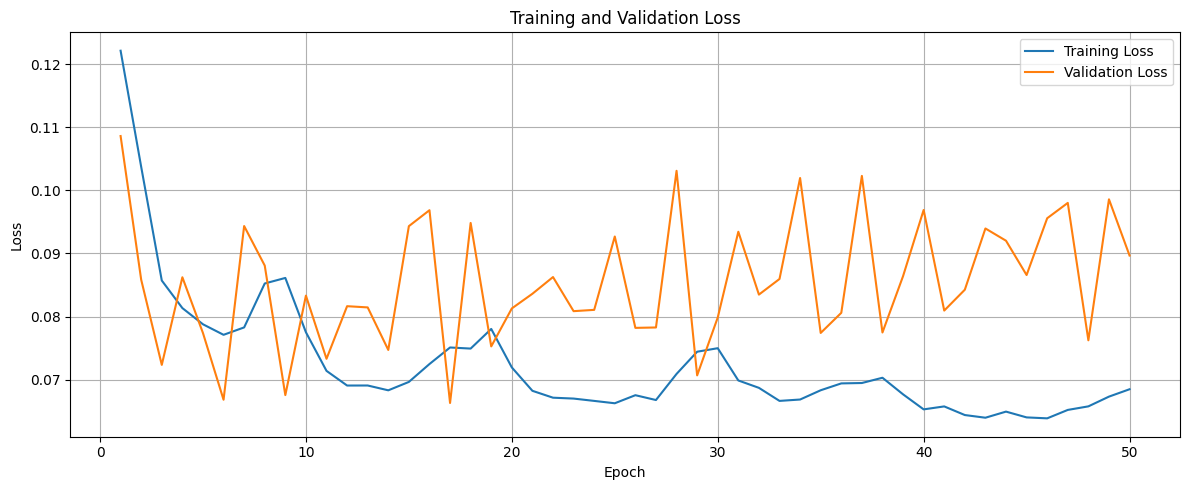

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


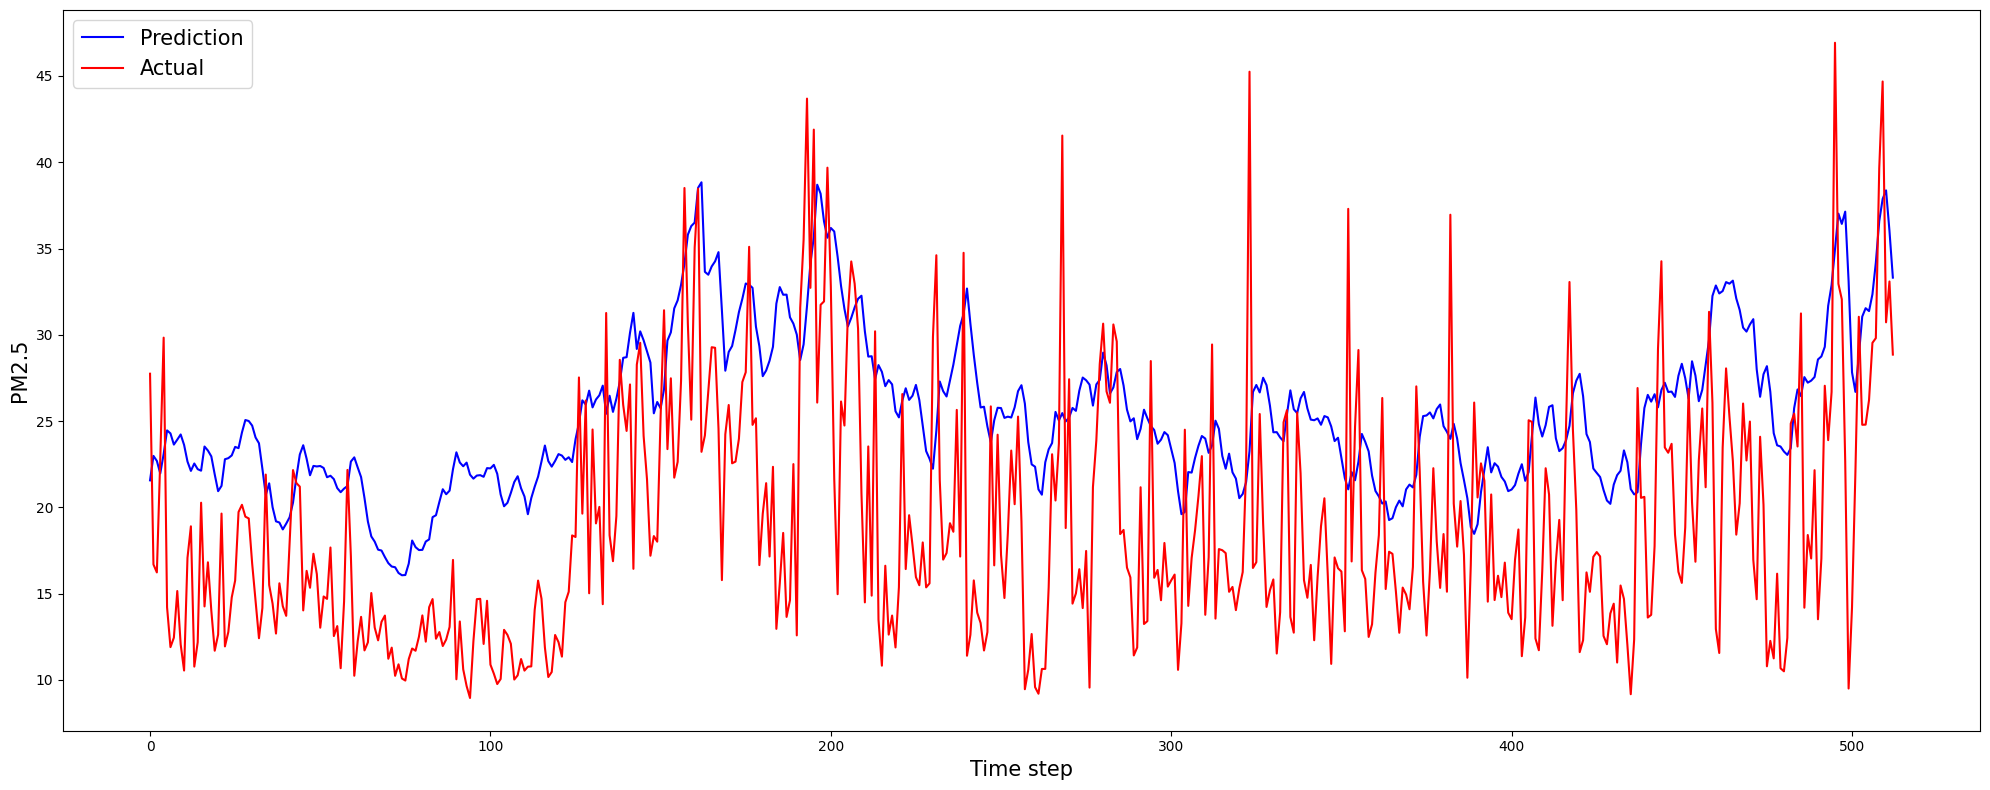

with_pm25_3km dim_reduction_method dim_after_reduction prediction       mae  \
0           Yes                 None                 N/A       LSTM  7.647748   

         mse        r2  
0  76.401387 -2.818927

In [31]:
# Prediction
lstmpred = LSTMPrediction(X_aod_scaled, y_aod_scaled,
                            aod_label_scaler,
                            val_percentage=0.2, test_percentage=0.2,
                            n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                            epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                            model_name=f"aod_{LSTMPrediction.class_name}_no_dim_reduction",
                            verbose=0)
lstmpred.get_model_info()
all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae, all_days_mse, avg_mse, all_days_r2, avg_r2 = lstmpred.execute()


# Visualize the prediction
plot_prediction(all_days_inv_y_pred, all_days_inv_y_test, conf["prediction"]["n_future"])

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["None"]
evaluation_board['dim_after_reduction'] += ["N/A"]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [avg_mae]
evaluation_board['mse'] += [avg_mse]
evaluation_board['r2'] += [avg_r2]
evaluation_board['with_pm25_3km'] += ["Yes"]
pd.DataFrame(evaluation_board)

#### No pm25_3km

Model: "aod_LSTMPrediction_no_dim_reduction_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 64),      │     21,504 │ input_layer_1[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 1, 64)     │          0 │ dropout_2[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 1, 64)     │     33,024 │ repeat_vector_1[… │
│                     │                   │            │ lstm_2[0][1],     │
│                     │                   │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1, 64)     │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 1, 100)    │      6,500 │ dropout_3[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 61,129 (238.79 KB)

 Trainable params: 61,129 (238.79 KB)

 Non-trainable params: 0 (0.00 B)

None


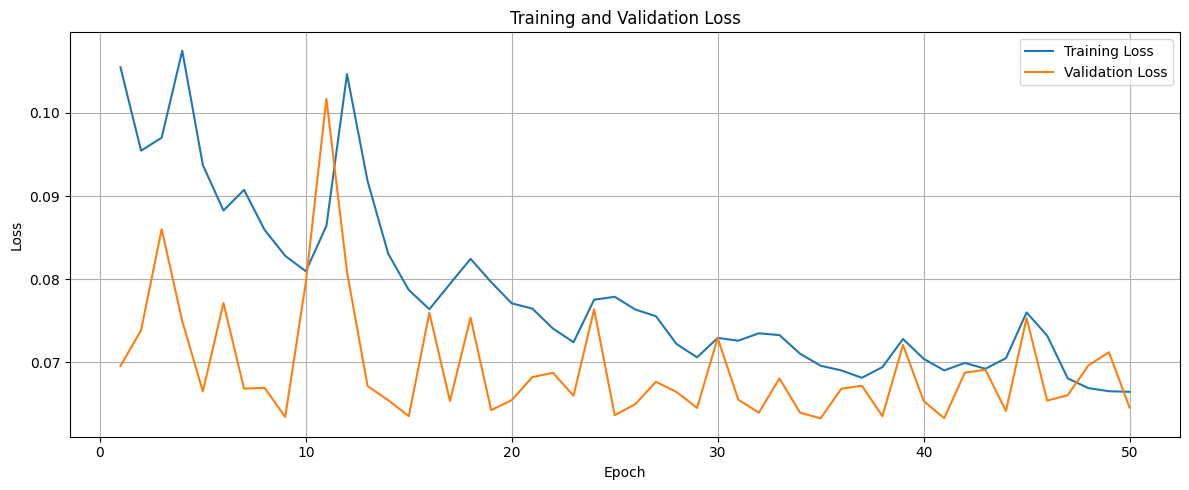

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


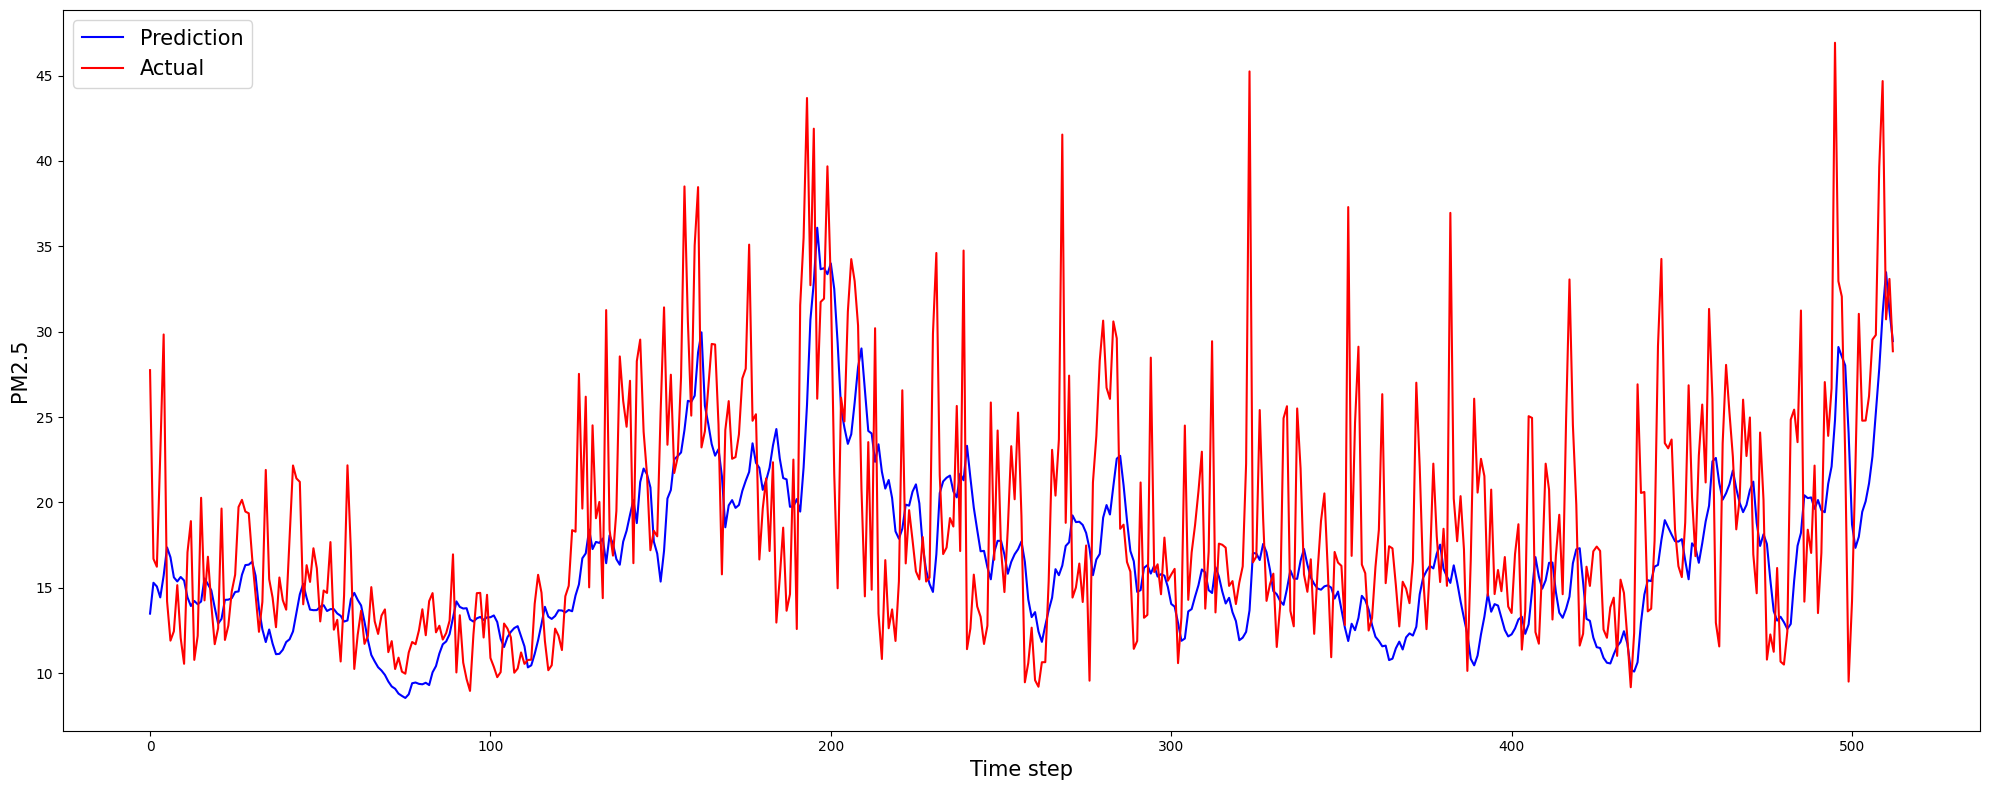

with_pm25_3km dim_reduction_method dim_after_reduction prediction       mae  \
0           Yes                 None                 N/A       LSTM  7.647748   
1            No                 None                 N/A       LSTM  4.637480   

         mse        r2  
0  76.401387 -2.818927  
1  40.051184 -0.741453

In [32]:
# Prediction
lstmpred = LSTMPrediction(X_aod_no_pm25_3km_scaled, y_aod_scaled,
                            aod_label_scaler,
                            val_percentage=0.2, test_percentage=0.2,
                            n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                            epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                            model_name=f"aod_{LSTMPrediction.class_name}_no_dim_reduction_no_pm25_3km",
                            verbose=0)
lstmpred.get_model_info()
all_days_inv_y_pred, all_days_inv_y_test, all_days_mae, avg_mae, all_days_mse, avg_mse, all_days_r2, avg_r2 = lstmpred.execute()

# Visualize the prediction
plot_prediction(all_days_inv_y_pred, all_days_inv_y_test, conf["prediction"]["n_future"])

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["None"]
evaluation_board['dim_after_reduction'] += ["N/A"]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [avg_mae]
evaluation_board['mse'] += [avg_mse]
evaluation_board['r2'] += [avg_r2]
evaluation_board['with_pm25_3km'] += ["No"]
pd.DataFrame(evaluation_board)

### Prediction + LSTM-Seq2Seq

#### Doing the loop

Model: "aod_LSTMSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 7, 100)    │     48,000 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 50),      │     30,200 │ lstm_4[0][0]      │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 13)        │        663 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 7, 13)     │          0 │ dense_4[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 7, 50)     │     12,800 │ repeat_vector_2[… │
│                     │                   │            │ lstm_5[0][1],     │
│                     │                   │            │ lstm_5[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 7, 100)    │     60,400 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 7, 19)     │      1,919 │ lstm_7[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,948 (1.76 MB)

 Trainable params: 153,982 (601.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 307,966 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_13_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,863 (308.06 KB)

 Trainable params: 78,863 (308.06 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ [(None, 64),      │     20,224 │ input_layer_4[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_3     │ (None, 1, 64)     │          0 │ dropout_4[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 1, 64)     │     33,024 │ repeat_vector_3[… │
│                     │                   │            │ lstm_8[0][1],     │
│                     │                   │            │ lstm_8[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1, 64)     │          0 │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 1, 100)    │      6,500 │ dropout_5[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 59,849 (233.79 KB)

 Trainable params: 59,849 (233.79 KB)

 Non-trainable params: 0 (0.00 B)

None


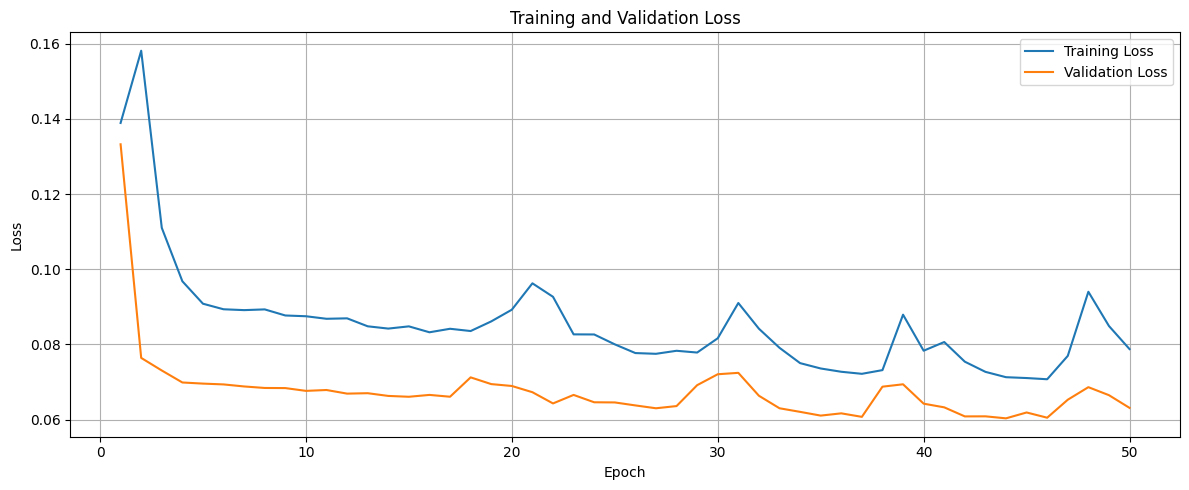

Model: "aod_LSTMSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 7, 100)    │     48,000 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_10[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 14)        │        714 │ lstm_11[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_4     │ (None, 7, 14)     │          0 │ dense_8[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 7, 50)     │     13,000 │ repeat_vector_4[… │
│                     │                   │            │ lstm_11[0][1],    │
│                     │                   │            │ lstm_11[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_12[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, 7, 19)     │      1,919 │ lstm_13[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 462,701 (1.77 MB)

 Trainable params: 154,233 (602.47 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,468 (1.18 MB)

None


Model: "aod_LSTMSeq2SeqReduction_14_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,914 (308.26 KB)

 Trainable params: 78,914 (308.26 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 7, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ [(None, 64),      │     20,480 │ input_layer_7[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ lstm_14[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_5     │ (None, 1, 64)     │          0 │ dropout_6[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_5[… │
│                     │                   │            │ lstm_14[0][1],    │
│                     │                   │            │ lstm_14[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 1, 64)     │          0 │ lstm_15[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, 1, 100)    │      6,500 │ dropout_7[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,105 (234.79 KB)

 Trainable params: 60,105 (234.79 KB)

 Non-trainable params: 0 (0.00 B)

None


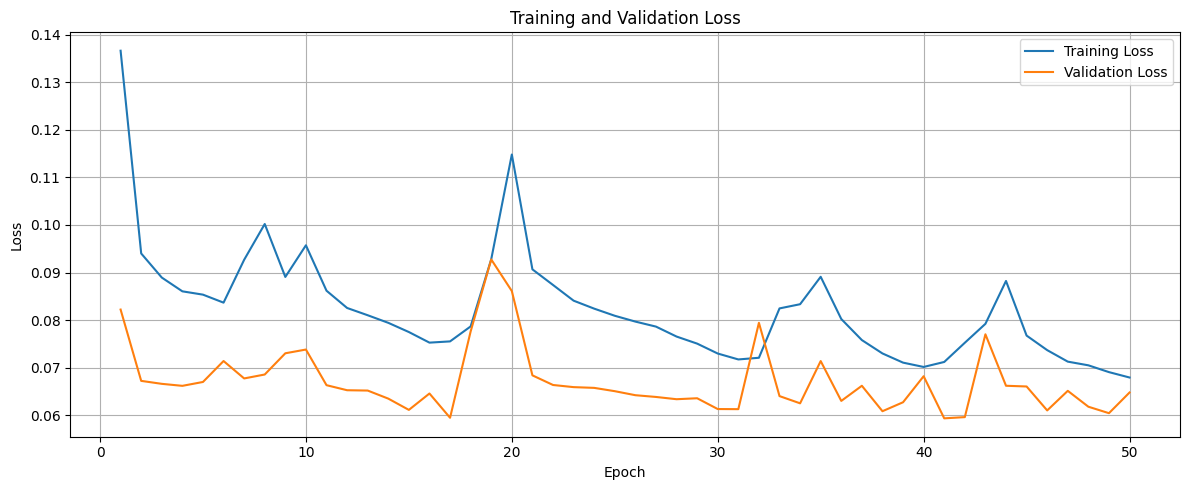

Model: "aod_LSTMSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 7, 100)    │     48,000 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_16[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 15)        │        765 │ lstm_17[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_6     │ (None, 7, 15)     │          0 │ dense_12[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 7, 50)     │     13,200 │ repeat_vector_6[… │
│                     │                   │            │ lstm_17[0][1],    │
│                     │                   │            │ lstm_17[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_18[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_10 │ (None, 7, 19)     │      1,919 │ lstm_19[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 463,454 (1.77 MB)

 Trainable params: 154,484 (603.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,970 (1.18 MB)

None


Model: "aod_LSTMSeq2SeqReduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,965 (308.46 KB)

 Trainable params: 78,965 (308.46 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 7, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_20 (LSTM)      │ [(None, 64),      │     20,736 │ input_layer_10[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ lstm_20[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_7     │ (None, 1, 64)     │          0 │ dropout_8[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_7[… │
│                     │                   │            │ lstm_20[0][1],    │
│                     │                   │            │ lstm_20[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 1, 64)     │          0 │ lstm_21[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_11 │ (None, 1, 100)    │      6,500 │ dropout_9[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,361 (235.79 KB)

 Trainable params: 60,361 (235.79 KB)

 Non-trainable params: 0 (0.00 B)

None


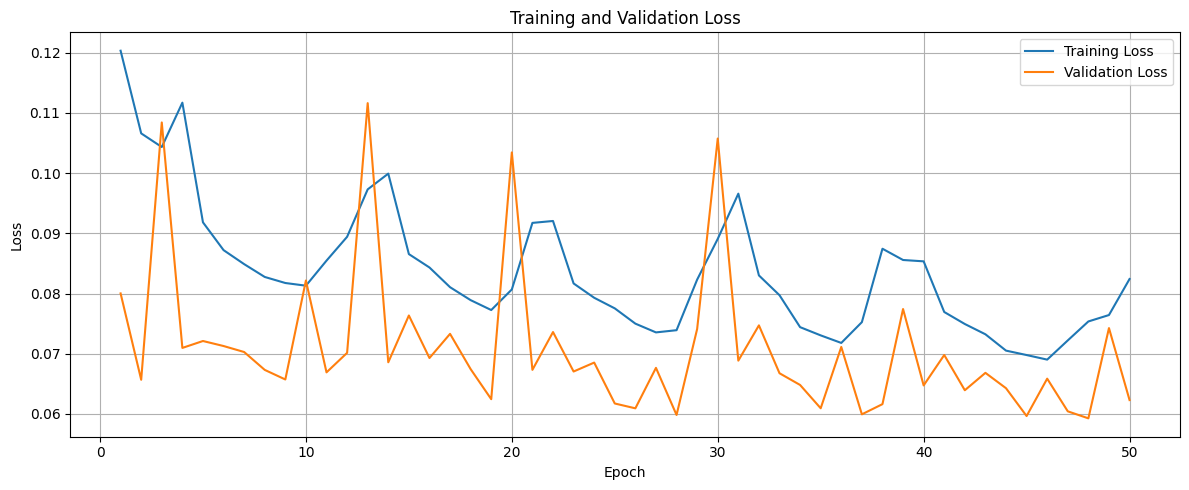

Model: "aod_LSTMSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_22 (LSTM)      │ (None, 7, 100)    │     48,000 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_23 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_22[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 16)        │        816 │ lstm_23[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_8     │ (None, 7, 16)     │          0 │ dense_16[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_24 (LSTM)      │ (None, 7, 50)     │     13,400 │ repeat_vector_8[… │
│                     │                   │            │ lstm_23[0][1],    │
│                     │                   │            │ lstm_23[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_24[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_13 │ (None, 7, 19)     │      1,919 │ lstm_25[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 464,207 (1.77 MB)

 Trainable params: 154,735 (604.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 309,472 (1.18 MB)

None


Model: "aod_LSTMSeq2SeqReduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,016 (308.66 KB)

 Trainable params: 79,016 (308.66 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_26 (LSTM)      │ [(None, 64),      │     20,992 │ input_layer_13[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64)        │          0 │ lstm_26[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_9     │ (None, 1, 64)     │          0 │ dropout_10[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_27 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_9[… │
│                     │                   │            │ lstm_26[0][1],    │
│                     │                   │            │ lstm_26[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 1, 64)     │          0 │ lstm_27[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_14 │ (None, 1, 100)    │      6,500 │ dropout_11[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_15 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,617 (236.79 KB)

 Trainable params: 60,617 (236.79 KB)

 Non-trainable params: 0 (0.00 B)

None


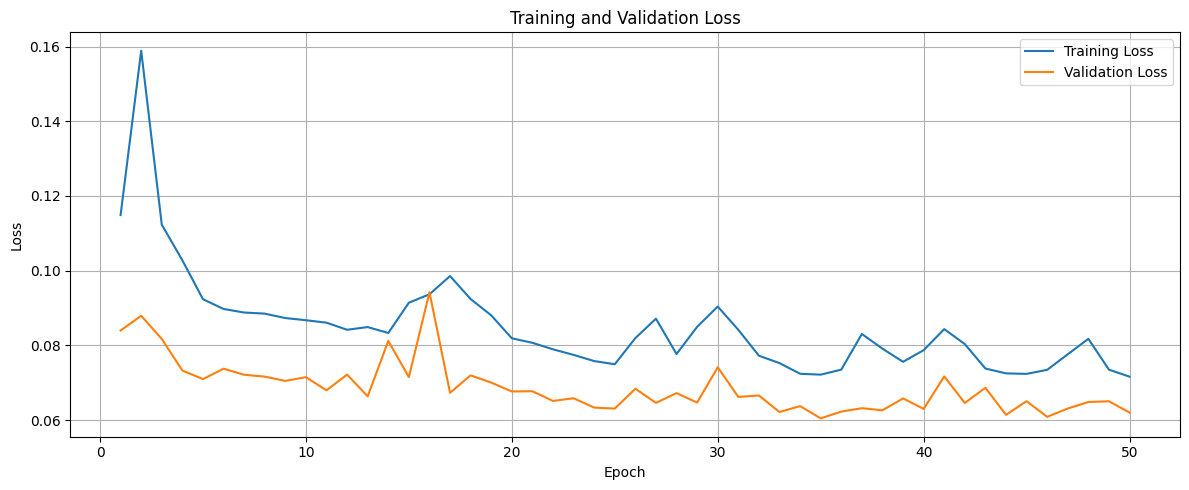

Model: "aod_LSTMSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_28 (LSTM)      │ (None, 7, 100)    │     48,000 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_29 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_28[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 17)        │        867 │ lstm_29[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_10    │ (None, 7, 17)     │          0 │ dense_20[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_30 (LSTM)      │ (None, 7, 50)     │     13,600 │ repeat_vector_10… │
│                     │                   │            │ lstm_29[0][1],    │
│                     │                   │            │ lstm_29[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_31 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_30[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_16 │ (None, 7, 19)     │      1,919 │ lstm_31[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 464,960 (1.77 MB)

 Trainable params: 154,986 (605.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 309,974 (1.18 MB)

None


Model: "aod_LSTMSeq2SeqReduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,067 (308.86 KB)

 Trainable params: 79,067 (308.86 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_32 (LSTM)      │ [(None, 64),      │     21,248 │ input_layer_16[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64)        │          0 │ lstm_32[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_11    │ (None, 1, 64)     │          0 │ dropout_12[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_33 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_11… │
│                     │                   │            │ lstm_32[0][1],    │
│                     │                   │            │ lstm_32[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 1, 64)     │          0 │ lstm_33[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_17 │ (None, 1, 100)    │      6,500 │ dropout_13[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_18 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,873 (237.79 KB)

 Trainable params: 60,873 (237.79 KB)

 Non-trainable params: 0 (0.00 B)

None


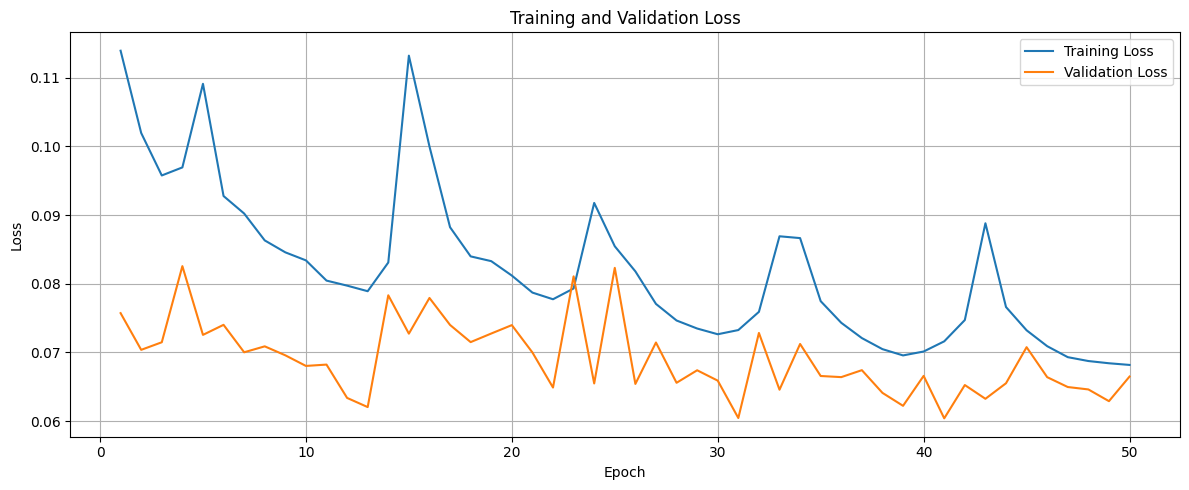

Model: "aod_LSTMSeq2SeqReduction_18_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_34 (LSTM)      │ (None, 7, 100)    │     48,000 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_35 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_34[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 18)        │        918 │ lstm_35[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_12    │ (None, 7, 18)     │          0 │ dense_24[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_36 (LSTM)      │ (None, 7, 50)     │     13,800 │ repeat_vector_12… │
│                     │                   │            │ lstm_35[0][1],    │
│                     │                   │            │ lstm_35[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_37 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_36[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_19 │ (None, 7, 19)     │      1,919 │ lstm_37[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 465,713 (1.78 MB)

 Trainable params: 155,237 (606.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 310,476 (1.18 MB)

None


Model: "aod_LSTMSeq2SeqReduction_18_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 7, 100)         │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,118 (309.05 KB)

 Trainable params: 79,118 (309.05 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_18_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_38 (LSTM)      │ [(None, 64),      │     21,504 │ input_layer_19[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ lstm_38[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_13    │ (None, 1, 64)     │          0 │ dropout_14[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_39 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_13… │
│                     │                   │            │ lstm_38[0][1],    │
│                     │                   │            │ lstm_38[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 1, 64)     │          0 │ lstm_39[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_20 │ (None, 1, 100)    │      6,500 │ dropout_15[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_21 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 61,129 (238.79 KB)

 Trainable params: 61,129 (238.79 KB)

 Non-trainable params: 0 (0.00 B)

None


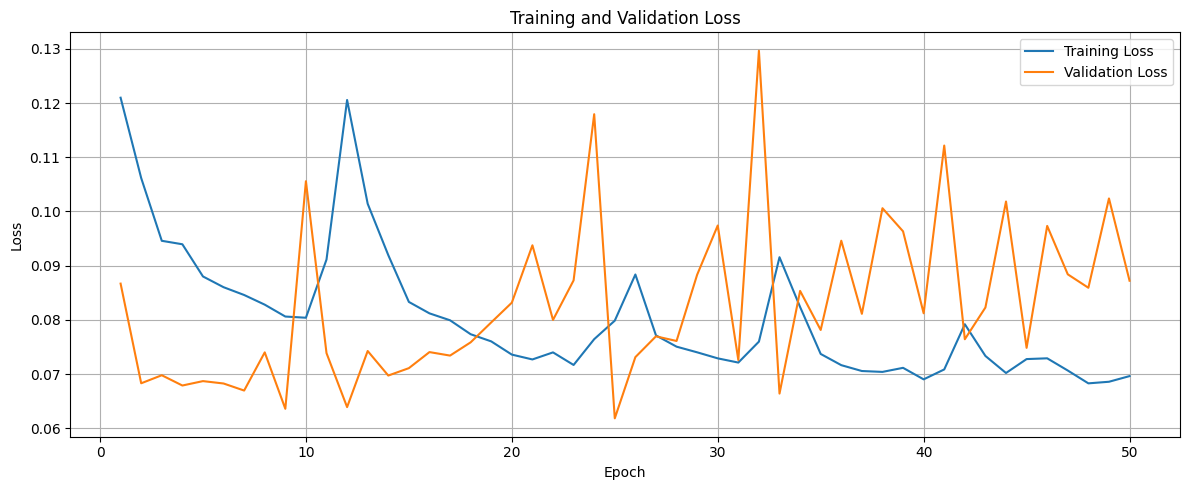

N = 13 - mae = 4.720873436656012, mse = 43.35715889210025, r2 = -12.791177422582539
N = 14 - mae = 4.555258520054121, mse = 34.467178308344764, r2 = -1.8912023511493063
N = 15 - mae = 4.6703293594350574, mse = 42.68483124679756, r2 = -10.858321967264313
N = 16 - mae = 4.745846700371168, mse = 41.7937569235739, r2 = -13.244765434962451
N = 17 - mae = 5.171318466248512, mse = 38.992144648339384, r2 = -2.177843093573118
N = 18 - mae = 6.984998259775114, mse = 63.64007695127445, r2 = -4.609309634938063


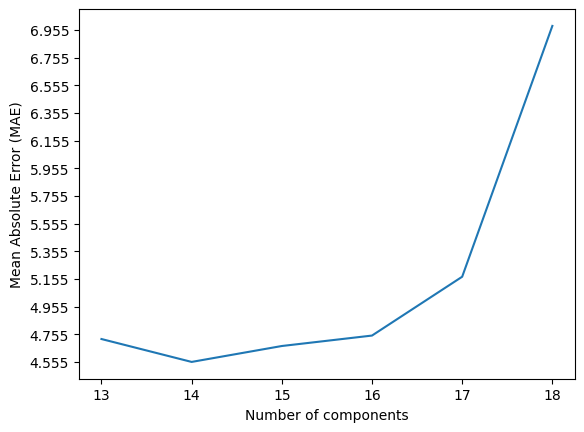

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


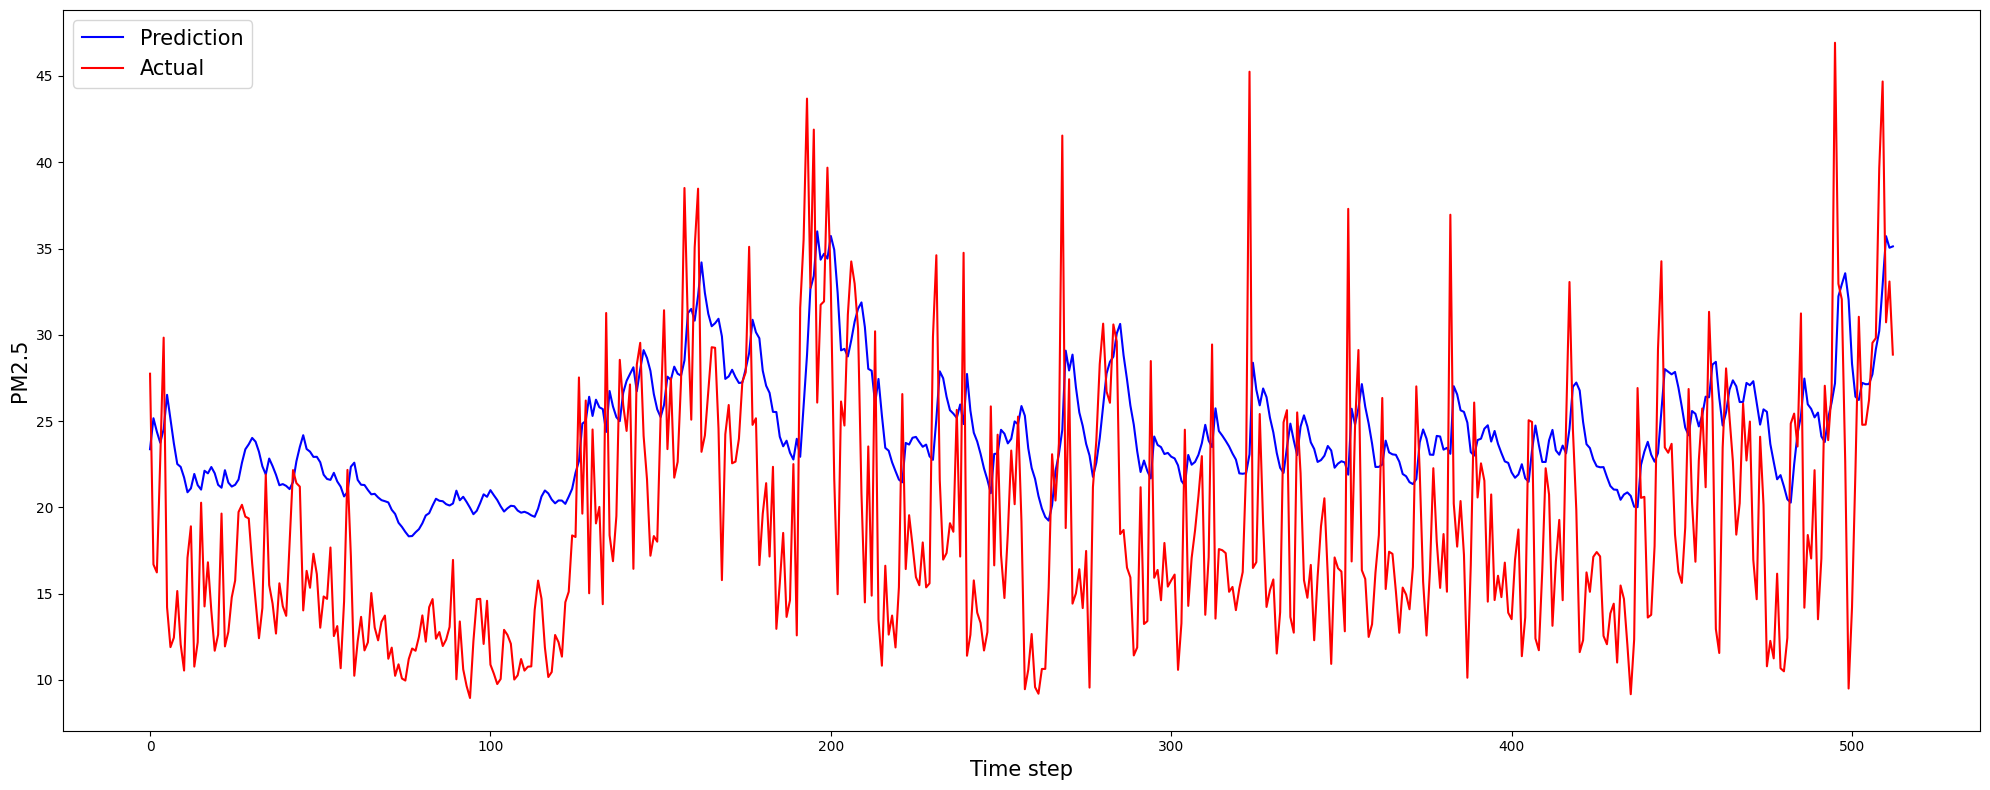

with_pm25_3km dim_reduction_method dim_after_reduction prediction       mae  \
0           Yes                 None                 N/A       LSTM  7.647748   
1            No                 None                 N/A       LSTM  4.637480   
2           Yes         LSTM-Seq2Seq                  18       LSTM  6.984998   

         mse        r2  
0  76.401387 -2.818927  
1  40.051184 -0.741453  
2  63.640077 -4.609310

In [33]:
loopresults = generate_loopresults(RANGE_OF_DIMENSION, LSTMSeq2SeqReduction, LSTMPrediction, X_aod_scaled, y_aod_scaled, aod_label_scaler)
best_mae, best_mse, best_r2, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = choose_the_best(loopresults)

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['mse'] += [best_mse]
evaluation_board['r2'] += [best_r2]
evaluation_board['with_pm25_3km'] += ["Yes"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [34]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_lstms2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_lstms2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_lstms2s_reduced_2021_2022.csv"))
df_lstms2s_reduced

aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2021-01-01      -0.596946       0.174180      -0.174505       1.126436   
2021-01-02      -0.596946       0.174180      -0.174505       1.126436   
2021-01-03      -0.595599       0.173241      -0.171430       1.125898   
2021-01-04      -0.593713       0.172574      -0.168867       1.124614   
2021-01-05      -0.590868       0.173887      -0.166037       1.124928   
...                   ...            ...            ...            ...   
2022-12-27      -0.354388      -0.005401      -0.502623       0.433297   
2022-12-28      -0.355264      -0.003085      -0.504533       0.431634   
2022-12-29      -0.352649       0.000489      -0.504244       0.426984   
2022-12-30      -0.356955       0.004232      -0.506348       0.432056   
2022-12-31      -0.359619       0.005148      -0.506339       0.436303   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2021-01-01      -1.525549      -0.086373       0.910435       1.152793   
2021-01-02      -1.525549      -0.086373       0.910435       1.152793   
2021-01-03      -1.524770      -0.084737       0.910980       1.153331   
2021-01-04      -1.523954      -0.084410       0.913615       1.154174   
2021-01-05      -1.525174      -0.084989       0.917631       1.157808   
...                   ...            ...            ...            ...   
2022-12-27      -0.522512       0.195916       0.367380       0.173093   
2022-12-28      -0.520123       0.195040       0.370299       0.174775   
2022-12-29      -0.516029       0.192206       0.372157       0.174276   
2022-12-30      -0.526807       0.189712       0.377200       0.177999   
2022-12-31      -0.534436       0.188957       0.376505       0.178950   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2021-01-01      -0.507395        0.228213       -1.916604       -0.173849   
2021-01-02      -0.507395        0.228213       -1.916604       -0.173849   
2021-01-03      -0.508060        0.231281       -1.914681       -0.172027   
2021-01-04      -0.506943        0.233390       -1.912674       -0.170767   
2021-01-05      -0.506296        0.234055       -1.914726       -0.169586   
...                   ...             ...             ...             ...   
2022-12-27      -0.166635        0.039873       -0.764106       -0.076755   
2022-12-28      -0.167673        0.038029       -0.759022       -0.074355   
2022-12-29      -0.168698        0.033766       -0.751626       -0.070324   
2022-12-30      -0.173242        0.031130       -0.757808       -0.069461   
2022-12-31      -0.173839        0.029083       -0.766171       -0.071057   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2021-01-01       -0.416192       -0.705491       -0.127460        0.697429   
2021-01-02       -0.416192       -0.705491       -0.127460        0.697429   
2021-01-03       -0.414642       -0.707692       -0.128963        0.700126   
2021-01-04       -0.414288       -0.710076       -0.130956        0.702970   
2021-01-05       -0.415482       -0.711985       -0.132488        0.706852   
...                    ...             ...             ...             ...   
2022-12-27       -0.181930       -0.426255        0.161151        0.297015   
2022-12-28       -0.175328       -0.432468        0.155566        0.299541   
2022-12-29       -0.169373       -0.435894        0.151059        0.299143   
2022-12-30       -0.165259       -0.442306        0.143615        0.300772   
2022-12-31       -0.168425       -0.440781        0.144107        0.298780   

            aod_feature_17  aod_feature_18  station  
time           

#### Doing the loop (no pm25_3km)

Model: "aod_LSTMSeq2SeqReduction_13_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_40 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_41 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_40[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 13)        │        663 │ lstm_41[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_14    │ (None, 7, 13)     │          0 │ dense_28[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_42 (LSTM)      │ (None, 7, 50)     │     12,800 │ repeat_vector_14… │
│                     │                   │            │ lstm_41[0][1],    │
│                     │                   │            │ lstm_41[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_43 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_42[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_22 │ (None, 7, 18)     │      1,818 │ lstm_43[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 460,445 (1.76 MB)

 Trainable params: 153,481 (599.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 306,964 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_13_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,463 (306.50 KB)

 Trainable params: 78,463 (306.50 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_13_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_44 (LSTM)      │ [(None, 64),      │     20,224 │ input_layer_22[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64)        │          0 │ lstm_44[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_15    │ (None, 1, 64)     │          0 │ dropout_16[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_45 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_15… │
│                     │                   │            │ lstm_44[0][1],    │
│                     │                   │            │ lstm_44[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 1, 64)     │          0 │ lstm_45[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_23 │ (None, 1, 100)    │      6,500 │ dropout_17[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_24 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 59,849 (233.79 KB)

 Trainable params: 59,849 (233.79 KB)

 Non-trainable params: 0 (0.00 B)

None


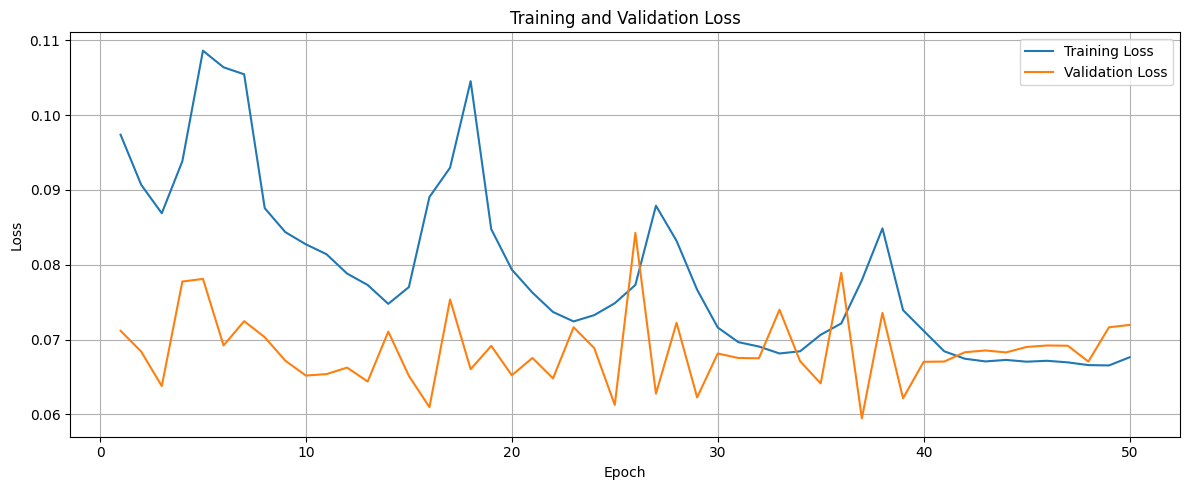

Model: "aod_LSTMSeq2SeqReduction_14_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_46 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_47 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_46[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 14)        │        714 │ lstm_47[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_16    │ (None, 7, 14)     │          0 │ dense_32[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_48 (LSTM)      │ (None, 7, 50)     │     13,000 │ repeat_vector_16… │
│                     │                   │            │ lstm_47[0][1],    │
│                     │                   │            │ lstm_47[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_49 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_48[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_25 │ (None, 7, 18)     │      1,818 │ lstm_49[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,198 (1.76 MB)

 Trainable params: 153,732 (600.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 307,466 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_14_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,514 (306.70 KB)

 Trainable params: 78,514 (306.70 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_14_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 7, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_50 (LSTM)      │ [(None, 64),      │     20,480 │ input_layer_25[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 64)        │          0 │ lstm_50[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_17    │ (None, 1, 64)     │          0 │ dropout_18[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_51 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_17… │
│                     │                   │            │ lstm_50[0][1],    │
│                     │                   │            │ lstm_50[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 1, 64)     │          0 │ lstm_51[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_26 │ (None, 1, 100)    │      6,500 │ dropout_19[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_27 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,105 (234.79 KB)

 Trainable params: 60,105 (234.79 KB)

 Non-trainable params: 0 (0.00 B)

None


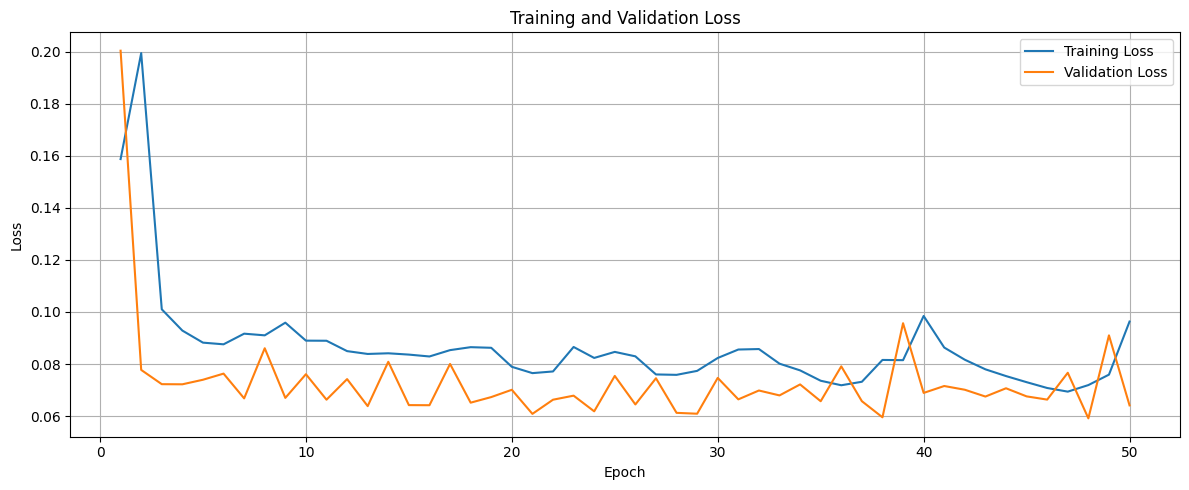

Model: "aod_LSTMSeq2SeqReduction_15_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_52 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_26[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_53 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_52[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 15)        │        765 │ lstm_53[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_18    │ (None, 7, 15)     │          0 │ dense_36[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_54 (LSTM)      │ (None, 7, 50)     │     13,200 │ repeat_vector_18… │
│                     │                   │            │ lstm_53[0][1],    │
│                     │                   │            │ lstm_53[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_55 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_54[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_28 │ (None, 7, 18)     │      1,818 │ lstm_55[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,951 (1.76 MB)

 Trainable params: 153,983 (601.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 307,968 (1.17 MB)

None


Model: "aod_LSTMSeq2SeqReduction_15_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,565 (306.89 KB)

 Trainable params: 78,565 (306.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_15_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 7, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_56 (LSTM)      │ [(None, 64),      │     20,736 │ input_layer_28[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 64)        │          0 │ lstm_56[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_19    │ (None, 1, 64)     │          0 │ dropout_20[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_57 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_19… │
│                     │                   │            │ lstm_56[0][1],    │
│                     │                   │            │ lstm_56[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 1, 64)     │          0 │ lstm_57[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_29 │ (None, 1, 100)    │      6,500 │ dropout_21[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_30 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,361 (235.79 KB)

 Trainable params: 60,361 (235.79 KB)

 Non-trainable params: 0 (0.00 B)

None


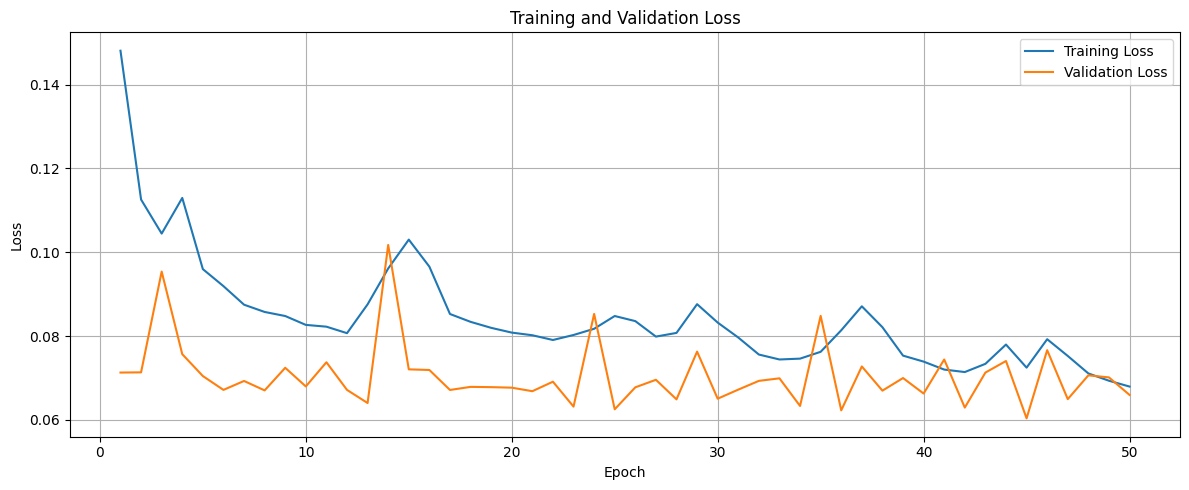

Model: "aod_LSTMSeq2SeqReduction_16_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_58 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_29[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_59 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_58[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 16)        │        816 │ lstm_59[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_20    │ (None, 7, 16)     │          0 │ dense_40[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_60 (LSTM)      │ (None, 7, 50)     │     13,400 │ repeat_vector_20… │
│                     │                   │            │ lstm_59[0][1],    │
│                     │                   │            │ lstm_59[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_61 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_60[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_31 │ (None, 7, 18)     │      1,818 │ lstm_61[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 462,704 (1.77 MB)

 Trainable params: 154,234 (602.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,470 (1.18 MB)

None


Model: "aod_LSTMSeq2SeqReduction_16_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_58 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_59 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,616 (307.09 KB)

 Trainable params: 78,616 (307.09 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_16_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_62 (LSTM)      │ [(None, 64),      │     20,992 │ input_layer_31[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 64)        │          0 │ lstm_62[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_21    │ (None, 1, 64)     │          0 │ dropout_22[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_63 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_21… │
│                     │                   │            │ lstm_62[0][1],    │
│                     │                   │            │ lstm_62[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 1, 64)     │          0 │ lstm_63[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_32 │ (None, 1, 100)    │      6,500 │ dropout_23[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_33 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,617 (236.79 KB)

 Trainable params: 60,617 (236.79 KB)

 Non-trainable params: 0 (0.00 B)

None


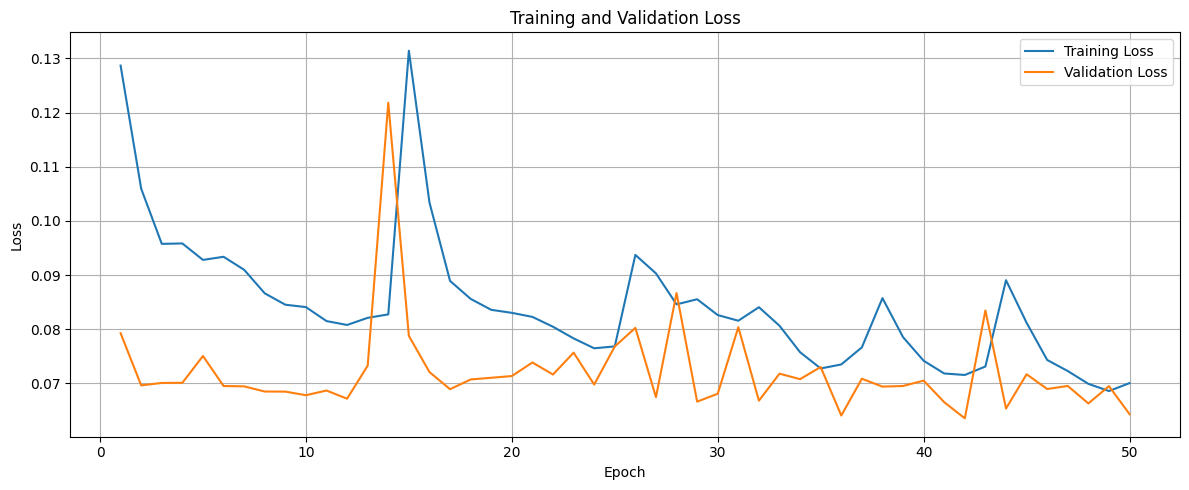

Model: "aod_LSTMSeq2SeqReduction_17_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_64 (LSTM)      │ (None, 7, 100)    │     47,600 │ input_layer_32[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_65 (LSTM)      │ [(None, 50),      │     30,200 │ lstm_64[0][0]     │
│                     │ (None, 50),       │            │                   │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 17)        │        867 │ lstm_65[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_22    │ (None, 7, 17)     │          0 │ dense_44[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_66 (LSTM)      │ (None, 7, 50)     │     13,600 │ repeat_vector_22… │
│                     │                   │            │ lstm_65[0][1],    │
│                     │                   │            │ lstm_65[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_67 (LSTM)      │ (None, 7, 100)    │     60,400 │ lstm_66[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_34 │ (None, 7, 18)     │      1,818 │ lstm_67[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 463,457 (1.77 MB)

 Trainable params: 154,485 (603.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,972 (1.18 MB)

None


Model: "aod_LSTMSeq2SeqReduction_17_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_64 (LSTM)                  │ (None, 7, 100)         │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_65 (LSTM)                  │ [(None, 50), (None,    │        30,200 │
│                                 │ 50), (None, 50)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,667 (307.29 KB)

 Trainable params: 78,667 (307.29 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_LSTMSeq2SeqReduction_17_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_68 (LSTM)      │ [(None, 64),      │     21,248 │ input_layer_34[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 64)        │          0 │ lstm_68[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_23    │ (None, 1, 64)     │          0 │ dropout_24[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_69 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_23… │
│                     │                   │            │ lstm_68[0][1],    │
│                     │                   │            │ lstm_68[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 1, 64)     │          0 │ lstm_69[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_35 │ (None, 1, 100)    │      6,500 │ dropout_25[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_36 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,873 (237.79 KB)

 Trainable params: 60,873 (237.79 KB)

 Non-trainable params: 0 (0.00 B)

None


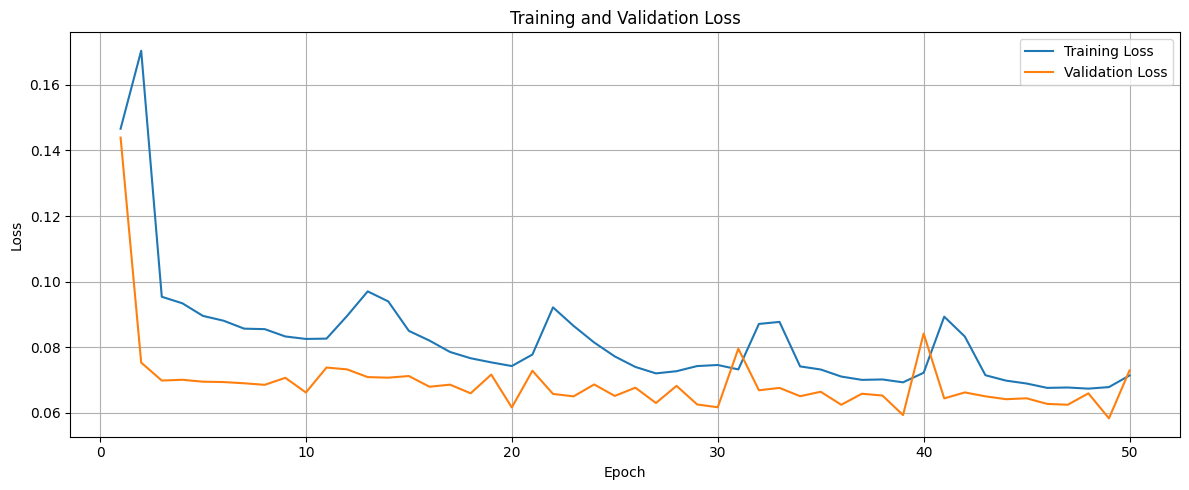

N = 13 - mae = 5.77450295588172, mse = 46.228003209123486, r2 = -2.6045226189637107
N = 14 - mae = 4.758031904748834, mse = 45.69862182799651, r2 = -12.562973676393707
N = 15 - mae = 5.106246083416227, mse = 38.19339377606797, r2 = -2.6282087682296003
N = 16 - mae = 4.602758218470191, mse = 36.464800536936146, r2 = -4.292934967055862
N = 17 - mae = 5.046139194129329, mse = 37.74345984935829, r2 = -2.677025328660046


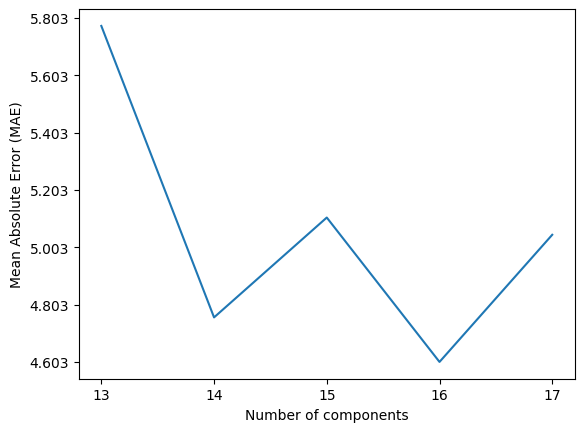

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


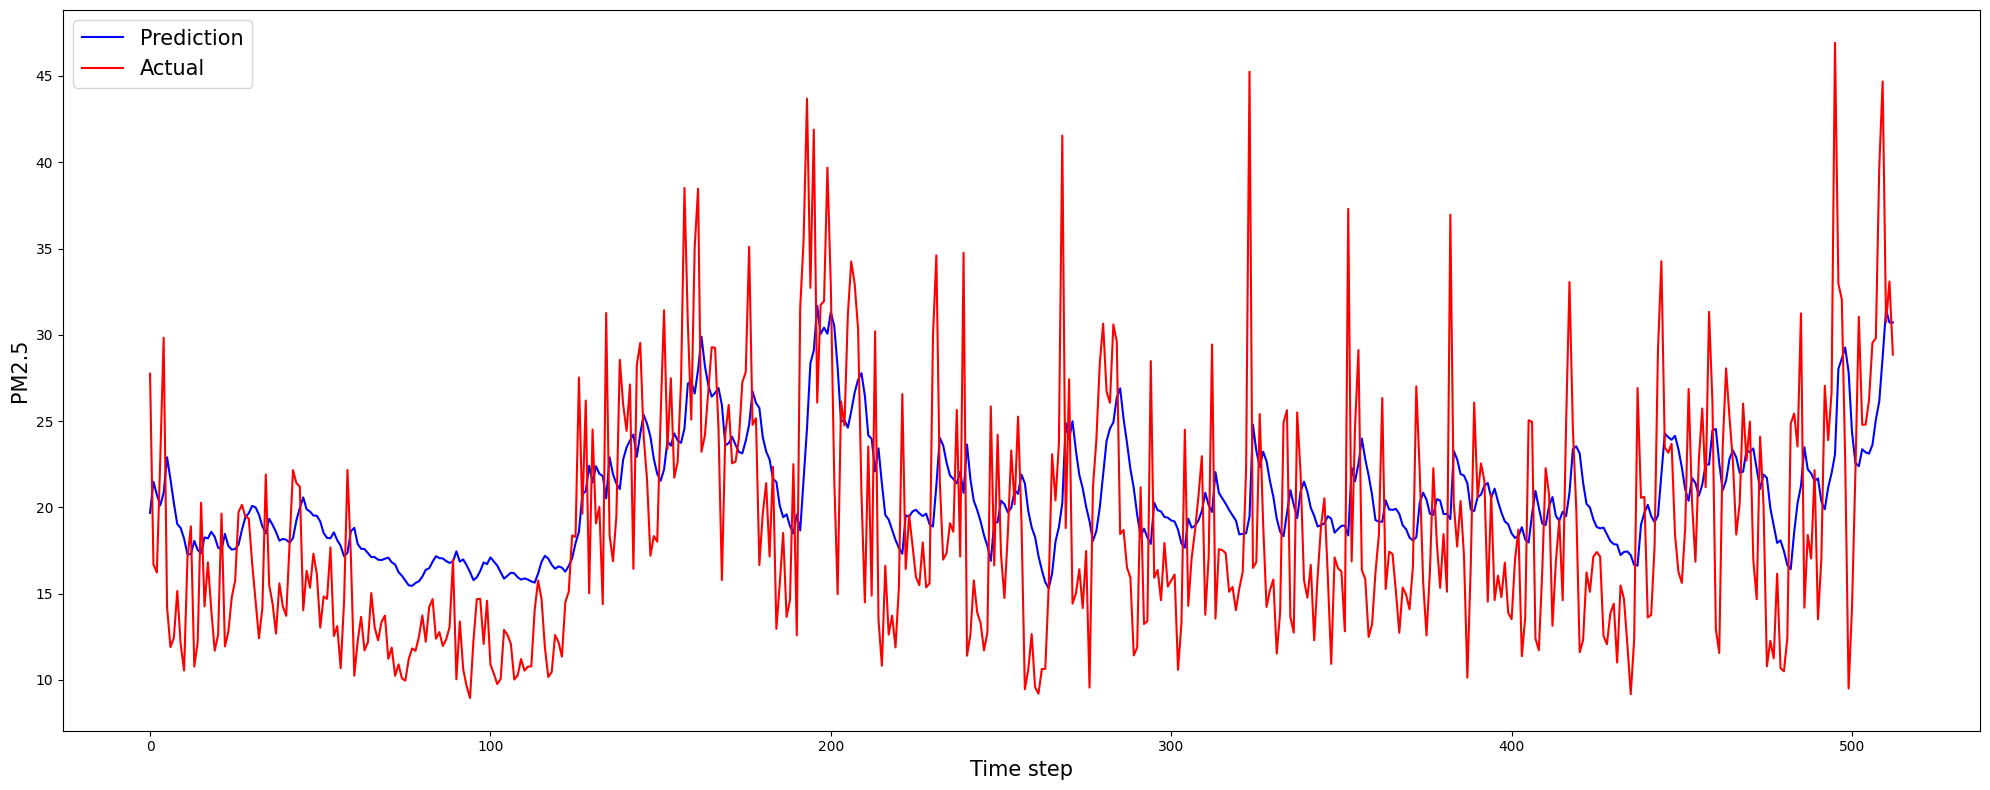

with_pm25_3km dim_reduction_method dim_after_reduction prediction       mae  \
0           Yes                 None                 N/A       LSTM  7.647748   
1            No                 None                 N/A       LSTM  4.637480   
2           Yes         LSTM-Seq2Seq                  18       LSTM  6.984998   
3            No         LSTM-Seq2Seq                  17       LSTM  5.046139   

         mse        r2  
0  76.401387 -2.818927  
1  40.051184 -0.741453  
2  63.640077 -4.609310  
3  37.743460 -2.677025

In [35]:
loopresults = generate_loopresults(RANGE_OF_DIMENSION_NO_PM25_3KM, LSTMSeq2SeqReduction, LSTMPrediction, X_aod_no_pm25_3km_scaled, y_aod_scaled, aod_label_scaler, False)
best_mae, best_mse, best_r2, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = choose_the_best(loopresults)

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["LSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['mse'] += [best_mse]
evaluation_board['r2'] += [best_r2]
evaluation_board['with_pm25_3km'] += ["No"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data (no pm25_3km)

In [36]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_lstms2s_reduced_no_pm25_3km = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_lstms2s_reduced_no_pm25_3km.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_lstms2s_reduced_2021_2022_no_pm25_3km.csv"))
df_lstms2s_reduced_no_pm25_3km

aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2021-01-01       0.982426      -0.377421       0.722007      -0.906386   
2021-01-02       0.982426      -0.377421       0.722007      -0.906386   
2021-01-03       0.981907      -0.376014       0.720182      -0.905523   
2021-01-04       0.979074      -0.374195       0.717812      -0.904089   
2021-01-05       0.974146      -0.372806       0.714368      -0.901495   
...                   ...            ...            ...            ...   
2022-12-27       0.663626      -0.354509       0.370401      -0.589550   
2022-12-28       0.658877      -0.355768       0.367051      -0.587362   
2022-12-29       0.651688      -0.355349       0.359378      -0.582995   
2022-12-30       0.649164      -0.354006       0.357636      -0.582790   
2022-12-31       0.650333      -0.354003       0.360520      -0.584623   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2021-01-01       0.304760      -0.705151      -0.376491       0.246123   
2021-01-02       0.304760      -0.705151      -0.376491       0.246123   
2021-01-03       0.304472      -0.703416      -0.374857       0.245670   
2021-01-04       0.304049      -0.699878      -0.373222       0.244901   
2021-01-05       0.304153      -0.695044      -0.370142       0.244233   
...                   ...            ...            ...            ...   
2022-12-27       0.443601      -0.489103       0.052369       0.058017   
2022-12-28       0.443492      -0.486069       0.054261       0.056719   
2022-12-29       0.440037      -0.483265       0.055327       0.056408   
2022-12-30       0.439165      -0.482451       0.054346       0.057419   
2022-12-31       0.441439      -0.484577       0.052973       0.058717   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2021-01-01      -0.784009        0.349168       -0.215568        0.361655   
2021-01-02      -0.784009        0.349168       -0.215568        0.361655   
2021-01-03      -0.782017        0.348744       -0.215845        0.361410   
2021-01-04      -0.779194        0.348463       -0.216280        0.361425   
2021-01-05      -0.774974        0.348183       -0.217542        0.361162   
...                   ...             ...             ...             ...   
2022-12-27      -0.513603        0.181145       -0.211084        0.005698   
2022-12-28      -0.509961        0.179969       -0.211324        0.004446   
2022-12-29      -0.507265        0.178912       -0.213333        0.005281   
2022-12-30      -0.506798        0.179874       -0.212927        0.007111   
2022-12-31      -0.508204        0.180326       -0.211393        0.007500   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2021-01-01        0.576723       -0.171746        0.495584       -0.305687   
2021-01-02        0.576723       -0.171746        0.495584       -0.305687   
2021-01-03        0.575164       -0.170521        0.494673       -0.304927   
2021-01-04        0.572195       -0.168993        0.492635       -0.304761   
2021-01-05        0.567811       -0.168883        0.490089       -0.304105   
...                    ...             ...             ...             ...   
2022-12-27        0.102976       -0.346425        0.318668        0.080748   
2022-12-28        0.098910       -0.348079        0.319108        0.082041   
2022-12-29        0.092380       -0.351688        0.318727        0.084279   
2022-12-30        0.090797       -0.351987        0.317857        0.083225   
2022-12-31        0.093924       -0.351420        0.317456        0.081272   

            aod_feature_17  station  
time                           

### Prediction + GRU-Seq2Seq

#### Doing the loop

Model: "aod_GRUSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_35      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 7, 100)    │     36,300 │ input_layer_35[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ [(None, 50),      │     22,800 │ gru[0][0]         │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 13)        │        663 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_24    │ (None, 7, 13)     │          0 │ dense_48[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 7, 50)     │      9,750 │ repeat_vector_24… │
│                     │                   │            │ gru_1[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 7, 100)    │     45,600 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_37 │ (None, 7, 19)     │      1,919 │ gru_3[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 351,098 (1.34 MB)

 Trainable params: 117,032 (457.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,066 (914.32 KB)

None


Model: "aod_GRUSeq2SeqReduction_13_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,763 (233.45 KB)

 Trainable params: 59,763 (233.45 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_13_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_37      │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_70 (LSTM)      │ [(None, 64),      │     20,224 │ input_layer_37[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 64)        │          0 │ lstm_70[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_25    │ (None, 1, 64)     │          0 │ dropout_26[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_71 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_25… │
│                     │                   │            │ lstm_70[0][1],    │
│                     │                   │            │ lstm_70[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 1, 64)     │          0 │ lstm_71[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_38 │ (None, 1, 100)    │      6,500 │ dropout_27[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_39 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 59,849 (233.79 KB)

 Trainable params: 59,849 (233.79 KB)

 Non-trainable params: 0 (0.00 B)

None


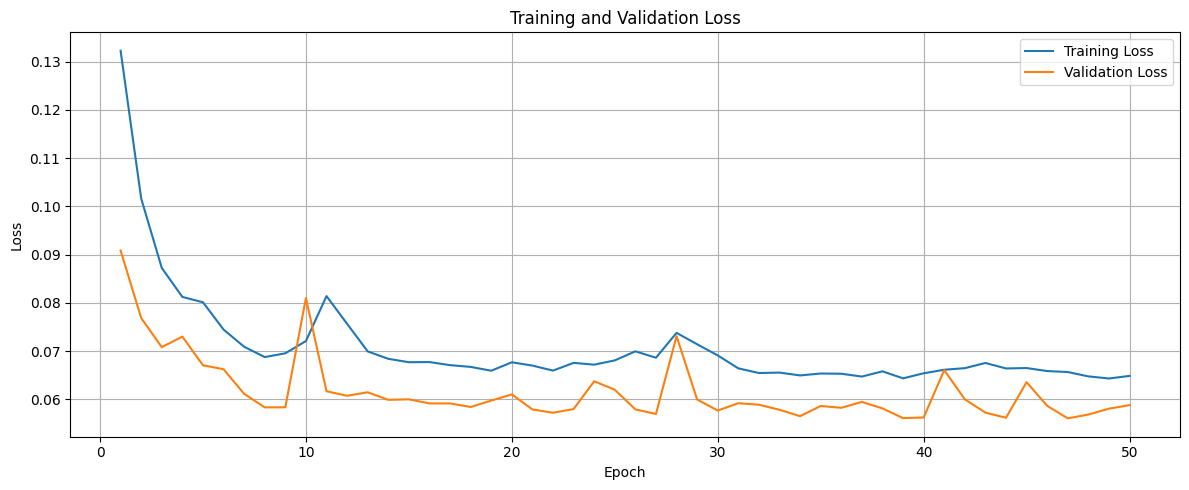

Model: "aod_GRUSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 7, 100)    │     36,300 │ input_layer_38[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ [(None, 50),      │     22,800 │ gru_4[0][0]       │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 14)        │        714 │ gru_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_26    │ (None, 7, 14)     │          0 │ dense_52[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_6 (GRU)         │ (None, 7, 50)     │      9,900 │ repeat_vector_26… │
│                     │                   │            │ gru_5[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_7 (GRU)         │ (None, 7, 100)    │     45,600 │ gru_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_40 │ (None, 7, 19)     │      1,919 │ gru_7[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 351,701 (1.34 MB)

 Trainable params: 117,233 (457.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,468 (915.89 KB)

None


Model: "aod_GRUSeq2SeqReduction_14_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_39 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 14)             │           714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,814 (233.65 KB)

 Trainable params: 59,814 (233.65 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_14_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40      │ (None, 7, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_72 (LSTM)      │ [(None, 64),      │     20,480 │ input_layer_40[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 64)        │          0 │ lstm_72[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_27    │ (None, 1, 64)     │          0 │ dropout_28[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_73 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_27… │
│                     │                   │            │ lstm_72[0][1],    │
│                     │                   │            │ lstm_72[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 1, 64)     │          0 │ lstm_73[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_41 │ (None, 1, 100)    │      6,500 │ dropout_29[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_42 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,105 (234.79 KB)

 Trainable params: 60,105 (234.79 KB)

 Non-trainable params: 0 (0.00 B)

None


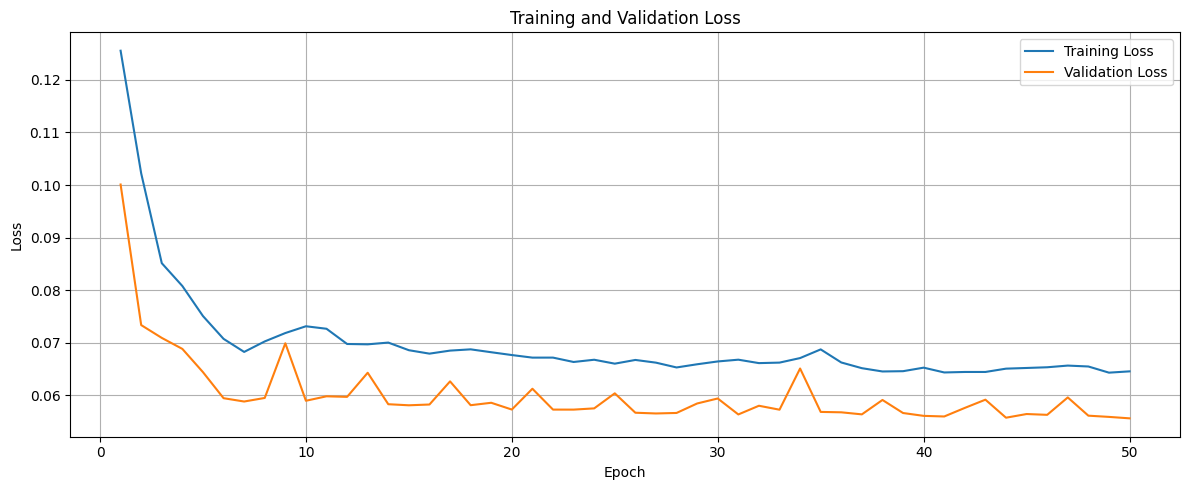

Model: "aod_GRUSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_41      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_8 (GRU)         │ (None, 7, 100)    │     36,300 │ input_layer_41[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_9 (GRU)         │ [(None, 50),      │     22,800 │ gru_8[0][0]       │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 15)        │        765 │ gru_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_28    │ (None, 7, 15)     │          0 │ dense_56[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_10 (GRU)        │ (None, 7, 50)     │     10,050 │ repeat_vector_28… │
│                     │                   │            │ gru_9[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_11 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_43 │ (None, 7, 19)     │      1,919 │ gru_11[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 352,304 (1.34 MB)

 Trainable params: 117,434 (458.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 234,870 (917.46 KB)

None


Model: "aod_GRUSeq2SeqReduction_15_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_9 (GRU)                     │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,865 (233.85 KB)

 Trainable params: 59,865 (233.85 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_15_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_43      │ (None, 7, 16)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_74 (LSTM)      │ [(None, 64),      │     20,736 │ input_layer_43[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 64)        │          0 │ lstm_74[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_29    │ (None, 1, 64)     │          0 │ dropout_30[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_75 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_29… │
│                     │                   │            │ lstm_74[0][1],    │
│                     │                   │            │ lstm_74[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 1, 64)     │          0 │ lstm_75[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_44 │ (None, 1, 100)    │      6,500 │ dropout_31[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_45 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,361 (235.79 KB)

 Trainable params: 60,361 (235.79 KB)

 Non-trainable params: 0 (0.00 B)

None


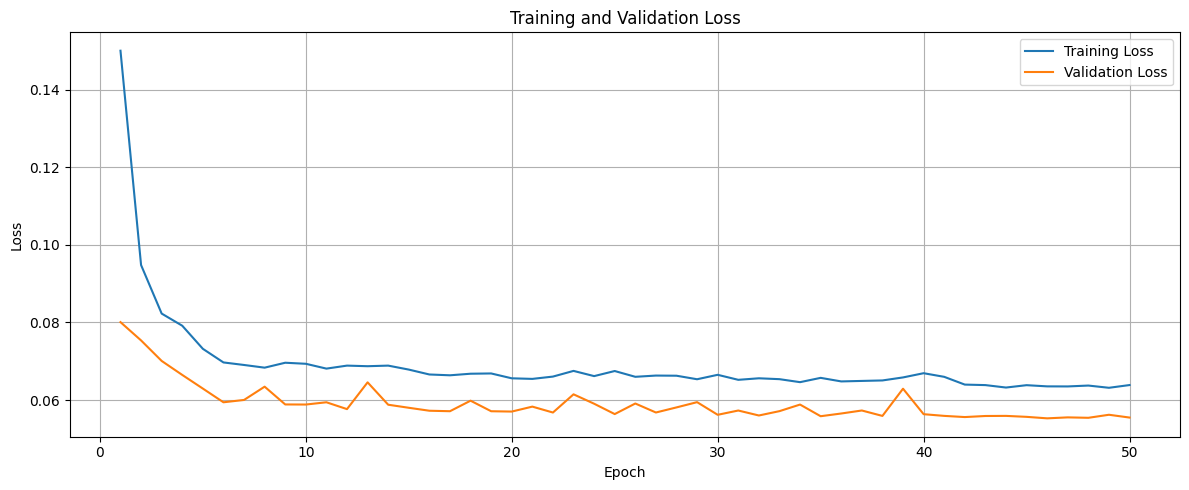

Model: "aod_GRUSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_44      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_12 (GRU)        │ (None, 7, 100)    │     36,300 │ input_layer_44[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_13 (GRU)        │ [(None, 50),      │     22,800 │ gru_12[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 16)        │        816 │ gru_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_30    │ (None, 7, 16)     │          0 │ dense_60[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_14 (GRU)        │ (None, 7, 50)     │     10,200 │ repeat_vector_30… │
│                     │                   │            │ gru_13[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_15 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_46 │ (None, 7, 19)     │      1,919 │ gru_15[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 352,907 (1.35 MB)

 Trainable params: 117,635 (459.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,272 (919.04 KB)

None


Model: "aod_GRUSeq2SeqReduction_16_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_12 (GRU)                    │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 16)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,916 (234.05 KB)

 Trainable params: 59,916 (234.05 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_16_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_46      │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_76 (LSTM)      │ [(None, 64),      │     20,992 │ input_layer_46[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 64)        │          0 │ lstm_76[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_31    │ (None, 1, 64)     │          0 │ dropout_32[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_77 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_31… │
│                     │                   │            │ lstm_76[0][1],    │
│                     │                   │            │ lstm_76[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 1, 64)     │          0 │ lstm_77[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_47 │ (None, 1, 100)    │      6,500 │ dropout_33[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_48 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,617 (236.79 KB)

 Trainable params: 60,617 (236.79 KB)

 Non-trainable params: 0 (0.00 B)

None


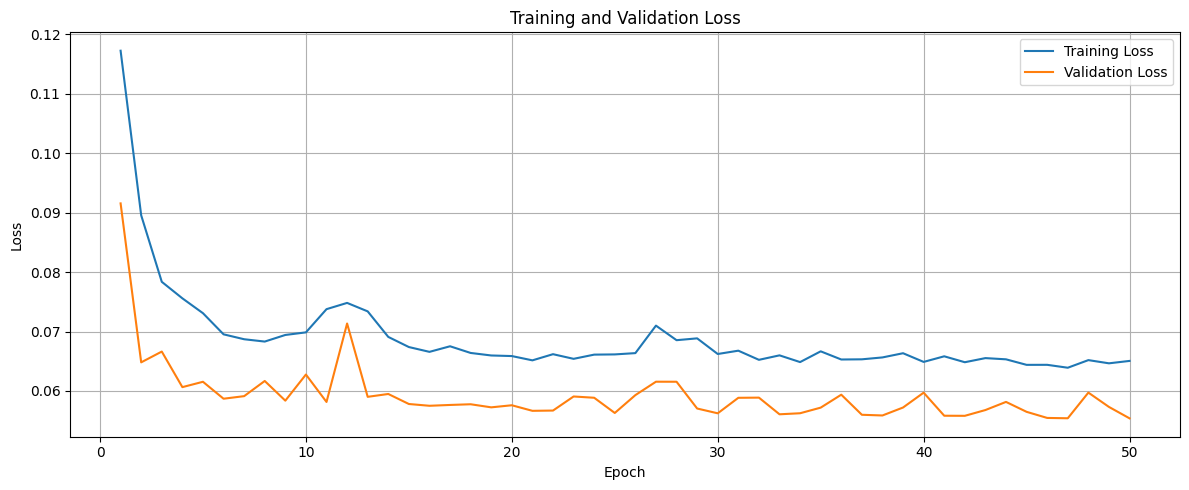

Model: "aod_GRUSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_47      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_16 (GRU)        │ (None, 7, 100)    │     36,300 │ input_layer_47[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_17 (GRU)        │ [(None, 50),      │     22,800 │ gru_16[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 17)        │        867 │ gru_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_32    │ (None, 7, 17)     │          0 │ dense_64[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_18 (GRU)        │ (None, 7, 50)     │     10,350 │ repeat_vector_32… │
│                     │                   │            │ gru_17[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_19 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_49 │ (None, 7, 19)     │      1,919 │ gru_19[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 353,510 (1.35 MB)

 Trainable params: 117,836 (460.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,674 (920.61 KB)

None


Model: "aod_GRUSeq2SeqReduction_17_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_48 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_16 (GRU)                    │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_17 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 17)             │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,967 (234.25 KB)

 Trainable params: 59,967 (234.25 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_17_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_49      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_78 (LSTM)      │ [(None, 64),      │     21,248 │ input_layer_49[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 64)        │          0 │ lstm_78[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_33    │ (None, 1, 64)     │          0 │ dropout_34[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_79 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_33… │
│                     │                   │            │ lstm_78[0][1],    │
│                     │                   │            │ lstm_78[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 1, 64)     │          0 │ lstm_79[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_50 │ (None, 1, 100)    │      6,500 │ dropout_35[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_51 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,873 (237.79 KB)

 Trainable params: 60,873 (237.79 KB)

 Non-trainable params: 0 (0.00 B)

None


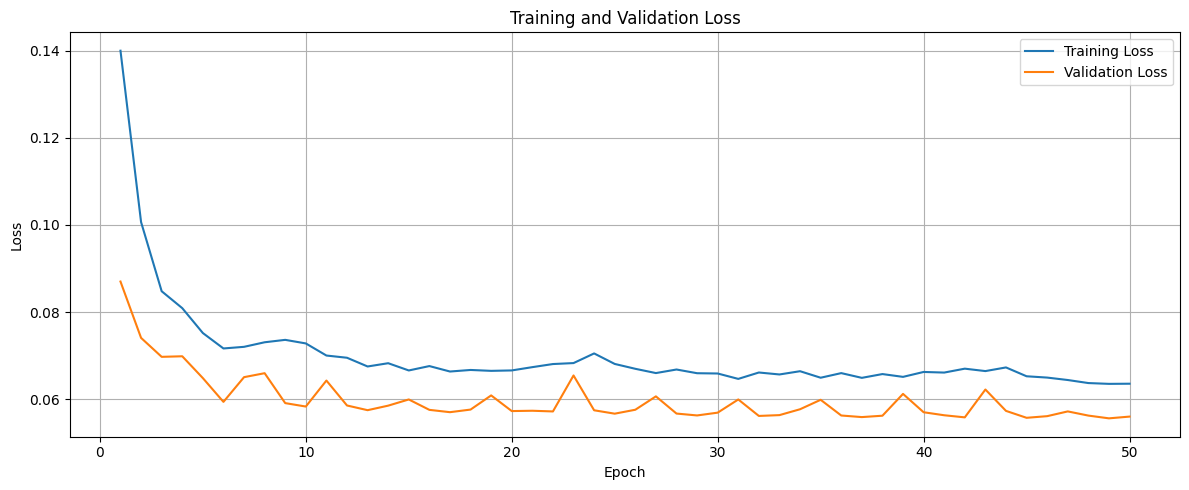

Model: "aod_GRUSeq2SeqReduction_18_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_50      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_20 (GRU)        │ (None, 7, 100)    │     36,300 │ input_layer_50[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_21 (GRU)        │ [(None, 50),      │     22,800 │ gru_20[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_68 (Dense)    │ (None, 18)        │        918 │ gru_21[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_34    │ (None, 7, 18)     │          0 │ dense_68[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_22 (GRU)        │ (None, 7, 50)     │     10,500 │ repeat_vector_34… │
│                     │                   │            │ gru_21[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_23 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_22[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_52 │ (None, 7, 19)     │      1,919 │ gru_23[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 354,113 (1.35 MB)

 Trainable params: 118,037 (461.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 236,076 (922.18 KB)

None


Model: "aod_GRUSeq2SeqReduction_18_features_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_51 (InputLayer)     │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_20 (GRU)                    │ (None, 7, 100)         │        36,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_21 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 18)             │           918 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,018 (234.45 KB)

 Trainable params: 60,018 (234.45 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_18_features"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_52      │ (None, 7, 19)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_80 (LSTM)      │ [(None, 64),      │     21,504 │ input_layer_52[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 64)        │          0 │ lstm_80[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_35    │ (None, 1, 64)     │          0 │ dropout_36[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_81 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_35… │
│                     │                   │            │ lstm_80[0][1],    │
│                     │                   │            │ lstm_80[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 1, 64)     │          0 │ lstm_81[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_53 │ (None, 1, 100)    │      6,500 │ dropout_37[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_54 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 61,129 (238.79 KB)

 Trainable params: 61,129 (238.79 KB)

 Non-trainable params: 0 (0.00 B)

None


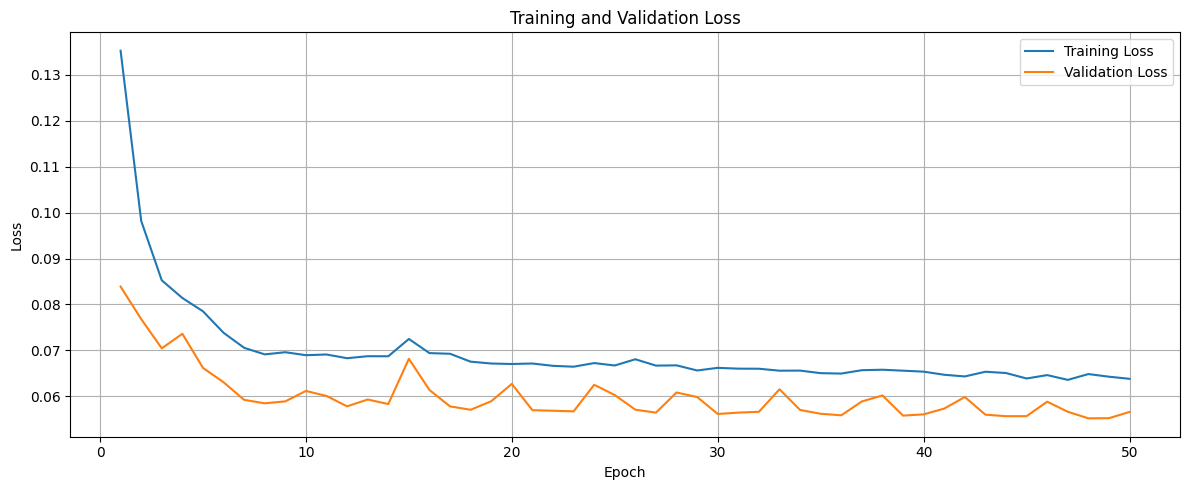

N = 13 - mae = 4.472622286928891, mse = 33.843587530499065, r2 = -0.782656087323444
N = 14 - mae = 4.170643579918221, mse = 33.98869738241109, r2 = -0.6143585875436284
N = 15 - mae = 4.149036503688417, mse = 32.658691843147906, r2 = -0.5407440981519867
N = 16 - mae = 4.161704104327435, mse = 34.04770101169925, r2 = -0.7041934755823844
N = 17 - mae = 4.1829382697466295, mse = 33.04822251641649, r2 = -0.5532588007892711
N = 18 - mae = 4.203386939603784, mse = 32.50056770452459, r2 = -0.5255884148508227


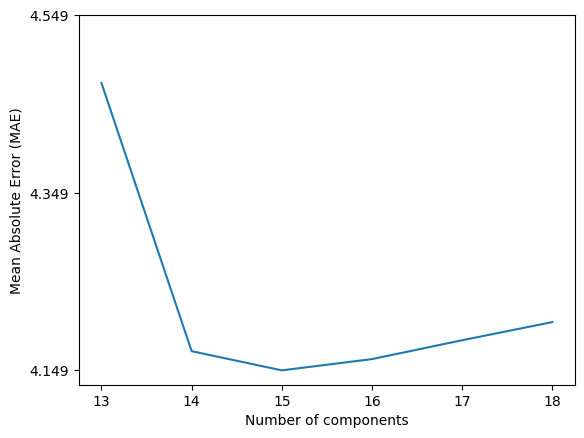

inv_y_pred.shape = (513, 1)
inv_y_test.shape = (513, 1)


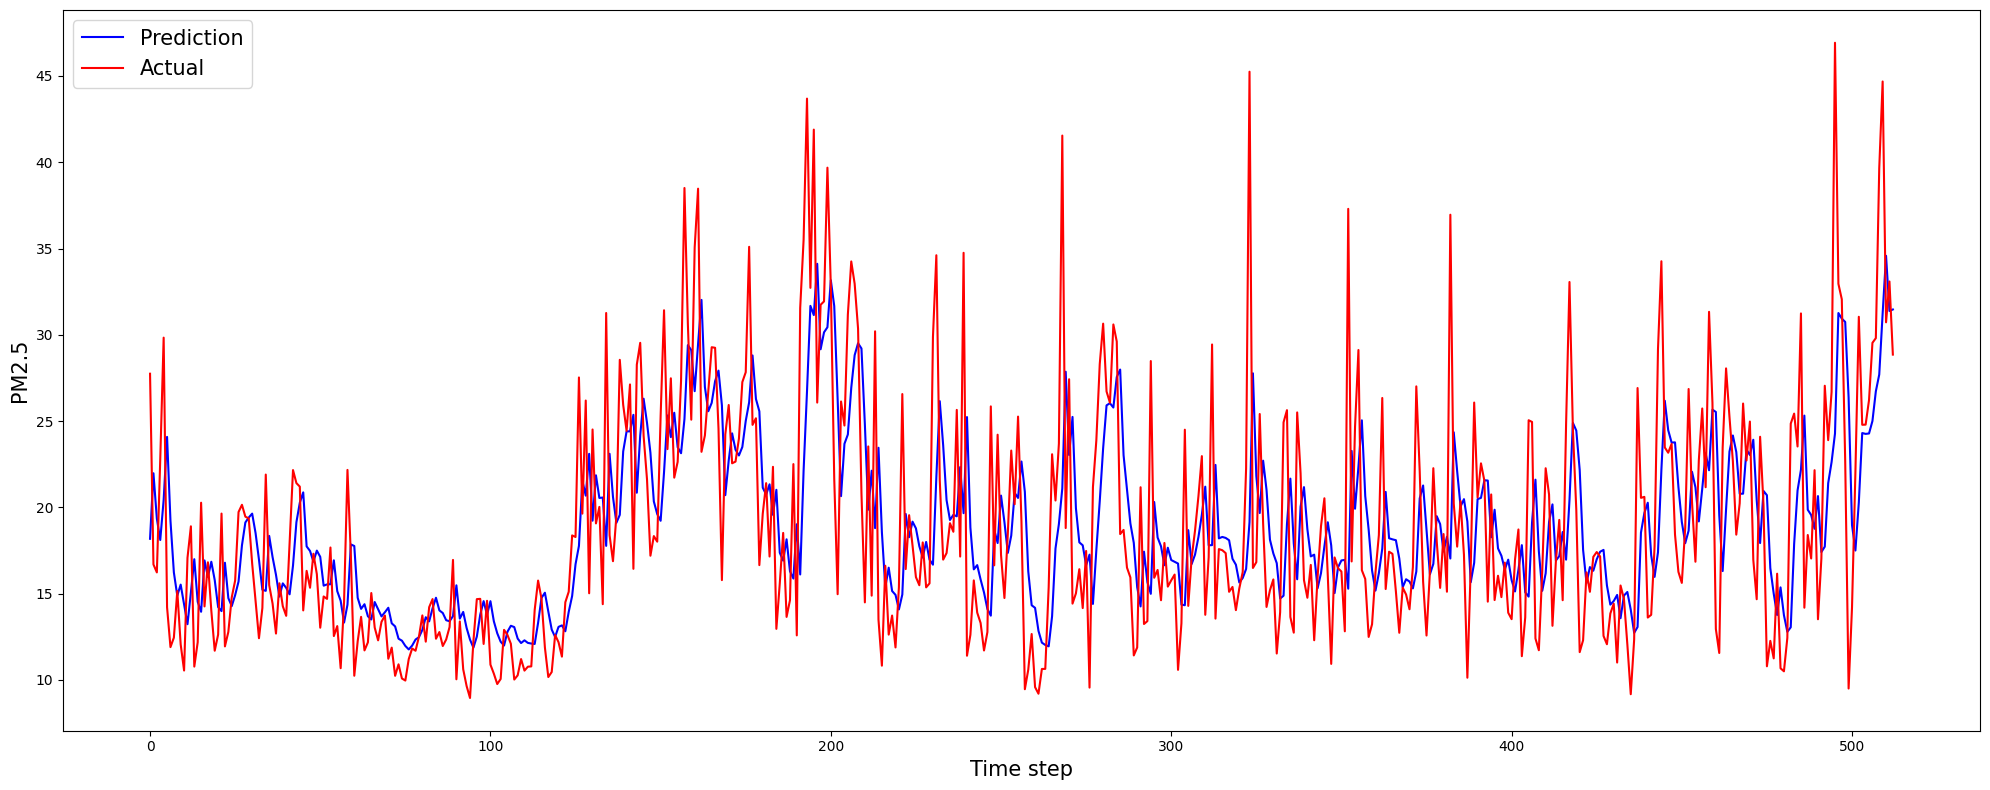

with_pm25_3km dim_reduction_method dim_after_reduction prediction       mae  \
0           Yes                 None                 N/A       LSTM  7.647748   
1            No                 None                 N/A       LSTM  4.637480   
2           Yes         LSTM-Seq2Seq                  18       LSTM  6.984998   
3            No         LSTM-Seq2Seq                  17       LSTM  5.046139   
4           Yes          GRU-Seq2Seq                  18       LSTM  4.203387   

         mse        r2  
0  76.401387 -2.818927  
1  40.051184 -0.741453  
2  63.640077 -4.609310  
3  37.743460 -2.677025  
4  32.500568 -0.525588

In [37]:
loopresults = generate_loopresults(RANGE_OF_DIMENSION, GRUSeq2SeqReduction, LSTMPrediction, X_aod_scaled, y_aod_scaled, aod_label_scaler)
best_mae, best_mse, best_r2, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = choose_the_best(loopresults)

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["GRU-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['mse'] += [best_mse]
evaluation_board['r2'] += [best_r2]
evaluation_board['with_pm25_3km'] += ["Yes"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [38]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_grus2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_grus2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_grus2s_reduced_2021_2022.csv"))
df_grus2s_reduced

aod_feature_1  aod_feature_2  aod_feature_3  aod_feature_4  \
time                                                                     
2021-01-01       0.031361       0.037240       0.029449       0.055702   
2021-01-02       0.031361       0.037240       0.029449       0.055702   
2021-01-03       0.031380       0.037135       0.029426       0.055646   
2021-01-04       0.031394       0.037147       0.029428       0.055646   
2021-01-05       0.031402       0.037141       0.029429       0.055640   
...                   ...            ...            ...            ...   
2022-12-27       0.097882       0.069992       0.026327       0.095323   
2022-12-28       0.096931       0.070140       0.026410       0.095256   
2022-12-29       0.097598       0.070762       0.026182       0.096219   
2022-12-30       0.098856       0.070852       0.025850       0.097134   
2022-12-31       0.101220       0.070555       0.025347       0.097938   

            aod_feature_5  aod_feature_6  aod_feature_7  aod_feature_8  \
time                                                                     
2021-01-01       0.160677       0.062244       0.098362       0.032833   
2021-01-02       0.160677       0.062244       0.098362       0.032833   
2021-01-03       0.160903       0.062185       0.098220       0.032957   
2021-01-04       0.161294       0.062111       0.098177       0.032949   
2021-01-05       0.161821       0.062015       0.098061       0.032820   
...                   ...            ...            ...            ...   
2022-12-27       0.074282       0.070807       0.076135       0.035315   
2022-12-28       0.074593       0.070758       0.076787       0.035215   
2022-12-29       0.073878       0.070603       0.076369       0.035075   
2022-12-30       0.072976       0.070170       0.075863       0.035220   
2022-12-31       0.072068       0.069635       0.075359       0.035590   

            aod_feature_9  aod_feature_10  aod_feature_11  aod_feature_12  \
time                                                                        
2021-01-01       0.025248        0.038885        0.081626        0.038791   
2021-01-02       0.025248        0.038885        0.081626        0.038791   
2021-01-03       0.025170        0.038878        0.081923        0.038794   
2021-01-04       0.025127        0.038791        0.081929        0.038767   
2021-01-05       0.025100        0.038699        0.082020        0.038681   
...                   ...             ...             ...             ...   
2022-12-27       0.033506        0.021335        0.075016        0.049622   
2022-12-28       0.033522        0.021591        0.074972        0.049569   
2022-12-29       0.033455        0.021423        0.074982        0.049593   
2022-12-30       0.033327        0.021262        0.075263        0.049392   
2022-12-31       0.033147        0.020932        0.075629        0.049300   

            aod_feature_13  aod_feature_14  aod_feature_15  aod_feature_16  \
time                                                                         
2021-01-01        0.004913        0.036951        0.078499        0.056336   
2021-01-02        0.004913        0.036951        0.078499        0.056336   
2021-01-03        0.004914        0.036840        0.078475        0.056491   
2021-01-04        0.004921        0.036797        0.078389        0.056740   
2021-01-05        0.004907        0.036708        0.078316        0.057043   
...                    ...             ...             ...             ...   
2022-12-27        0.010919        0.044491        0.083927        0.048046   
2022-12-28        0.010925        0.044563        0.083719        0.048226   
2022-12-29        0.010990        0.044600        0.083732        0.048177   
2022-12-30        0.011018        0.044677        0.084170        0.048296   
2022-12-31        0.011014        0.044515        0.084984        0.048117   

            aod_feature_17  aod_feature_18  station  
time           

#### Doing the loop (no pm25_3km)

In [ ]:
loopresults = generate_loopresults(RANGE_OF_DIMENSION_NO_PM25_3KM, GRUSeq2SeqReduction, LSTMPrediction, X_aod_no_pm25_3km_scaled, y_aod_scaled, aod_label_scaler, False)
best_mae, best_mse, best_r2, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = choose_the_best(loopresults)

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["GRU-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['mse'] += [best_mse]
evaluation_board['r2'] += [best_r2]
evaluation_board['with_pm25_3km'] += ["No"]
pd.DataFrame(evaluation_board)

Model: "aod_GRUSeq2SeqReduction_13_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_53      │ (None, 7, 18)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_24 (GRU)        │ (None, 7, 100)    │     36,000 │ input_layer_53[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_25 (GRU)        │ [(None, 50),      │     22,800 │ gru_24[0][0]      │
│                     │ (None, 50)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_72 (Dense)    │ (None, 13)        │        663 │ gru_25[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_36    │ (None, 7, 13)     │          0 │ dense_72[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_26 (GRU)        │ (None, 7, 50)     │      9,750 │ repeat_vector_36… │
│                     │                   │            │ gru_25[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_27 (GRU)        │ (None, 7, 100)    │     45,600 │ gru_26[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_55 │ (None, 7, 18)     │      1,818 │ gru_27[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 349,895 (1.33 MB)

 Trainable params: 116,631 (455.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 233,264 (911.19 KB)

None


Model: "aod_GRUSeq2SeqReduction_13_features_no_pm25_3km_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_54 (InputLayer)     │ (None, 7, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_24 (GRU)                    │ (None, 7, 100)         │        36,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_25 (GRU)                    │ [(None, 50), (None,    │        22,800 │
│                                 │ 50)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 13)             │           663 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,463 (232.28 KB)

 Trainable params: 59,463 (232.28 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "aod_LSTMPrediction_with_GRUSeq2SeqReduction_13_features_no_pm25_3km"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_55      │ (None, 7, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_82 (LSTM)      │ [(None, 64),      │     20,224 │ input_layer_55[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 64)        │          0 │ lstm_82[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_37    │ (None, 1, 64)     │          0 │ dropout_38[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_83 (LSTM)      │ (None, 1, 64)     │     33,024 │ repeat_vector_37… │
│                     │                   │            │ lstm_82[0][1],    │
│                     │                   │            │ lstm_82[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 1, 64)     │          0 │ lstm_83[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_56 │ (None, 1, 100)    │      6,500 │ dropout_39[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_57 │ (None, 1, 1)      │        101 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 59,849 (233.79 KB)

 Trainable params: 59,849 (233.79 KB)

 Non-trainable params: 0 (0.00 B)

None


#### Prepare reduced data (no pm25_3km)

In [ ]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_grus2s_reduced_no_pm25_3km = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_grus2s_reduced_no_pm25_3km.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_grus2s_reduced_2021_2022_no_pm25_3km.csv"))
df_grus2s_reduced_no_pm25_3km

### Prediction + CNN-LSTM Seq2seq

#### Doing the loop

In [ ]:
loopresults = generate_loopresults(RANGE_OF_DIMENSION, CNNLSTMSeq2SeqReduction, LSTMPrediction, X_aod_scaled, y_aod_scaled, aod_label_scaler)
best_mae, best_mse, best_r2, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = choose_the_best(loopresults)

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["CNNLSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['mse'] += [best_mse]
evaluation_board['r2'] += [best_r2]
evaluation_board['with_pm25_3km'] += ["Yes"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data

In [ ]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_cnnlstms2s_reduced = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_cnnlstms2s_reduced.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_cnnlstms2s_reduced_2021_2022.csv"))
df_cnnlstms2s_reduced

#### Doing the loop (no pm25_3km)

In [ ]:
loopresults = generate_loopresults(RANGE_OF_DIMENSION, CNNLSTMSeq2SeqReduction, LSTMPrediction, X_aod_no_pm25_3km_scaled, y_aod_scaled, aod_label_scaler, False)
best_mae, best_mse, best_r2, best_num_of_components, best_encoded_data, best_evaluation_data, best_encoder_model_path = choose_the_best(loopresults)

# Print out the evaluation board
evaluation_board['dim_reduction_method'] += ["CNNLSTM-Seq2Seq"]
evaluation_board['dim_after_reduction'] += [best_num_of_components]
evaluation_board['prediction'] += ["LSTM"]
evaluation_board['mae'] += [best_mae]
evaluation_board['mse'] += [best_mse]
evaluation_board['r2'] += [best_r2]
evaluation_board['with_pm25_3km'] += ["No"]
pd.DataFrame(evaluation_board)

#### Prepare reduced data (no pm25_3km)

In [ ]:
# Copy the best reduction model to target directory
shutil.copy(best_encoder_model_path, conf["workspace"]["best_reduction_models_dir"])

# Prepare the reduced data
df_cnnlstms2s_reduced_no_pm25_3km = prepareReducedData(best_encoded_data, aod_time_indices, aod_station_column)
df_cnnlstms2s_reduced_no_pm25_3km.to_csv(os.path.join(conf["workspace"]["best_reduced_data"], "df_cnnlstms2s_reduced_2021_2022_no_pm25_3km.csv"))
df_cnnlstms2s_reduced_no_pm25_3km

## Compare the score

In [ ]:
y_aod_scaled

### LSTM-Seq2Seq

In [ ]:
print(df_lstms2s_reduced.shape)
df_lstms2s_reduced

In [ ]:
y_pred = predictLSTMNoSplit(df_lstms2s_reduced.drop(columns=["station"], axis=1), y_aod_scaled,
                           n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                           epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                           model_name=f"aod_lstm_prediction_no_split_with_lstms2s_dim_reduction_{df_lstms2s_reduced.shape[-1]}_features",
                           verbose=0)

In [ ]:
print(y_pred.shape)
y_pred

In [ ]:
y_pred_reshaped = y_pred.reshape([-1, 1])
df_y_pred = pd.DataFrame(y_pred_reshaped)
df_y_pred

In [ ]:
inv_y_aod = aod_label_scaler.inverse_transform(y_aod_scaled)
inv_y_aod

In [ ]:
inv_y_pred = aod_label_scaler.inverse_transform(df_y_pred)
inv_y_pred

In [ ]:
# Print out the MAE
print(mean_absolute_error(inv_y_aod, inv_y_pred))
print(mean_absolute_error(df_aod_raw["pm25"], df_aod_raw["pm25_3km"]))

# Visualization
plot_2_data(data1=inv_y_pred,
            data2=inv_y_aod,
            datalabel1="Prediction",
            datalabel2="Actual",
            xlabel="Time step",
            ylabel="PM2.5")

### GRU-Seq2Seq

In [ ]:
print(df_grus2s_reduced.shape)
df_grus2s_reduced

In [ ]:
y_pred = predictLSTMNoSplit(df_grus2s_reduced.drop(columns=["station"], axis=1), y_aod_scaled,
                           n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                           epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                           model_name=f"aod_gru_s2s_lstm_predict_no_split",
                           verbose=0)

In [ ]:
print(y_pred.shape)
y_pred

In [ ]:
y_pred_reshaped = y_pred.reshape([-1, 1])
df_y_pred = pd.DataFrame(y_pred_reshaped)
df_y_pred

In [ ]:
inv_y_aod = aod_label_scaler.inverse_transform(y_aod_scaled)
inv_y_aod

In [ ]:
inv_y_pred = aod_label_scaler.inverse_transform(df_y_pred)
inv_y_pred

In [ ]:
mean_absolute_error(inv_y_aod, inv_y_pred)

In [ ]:
mean_absolute_error(df_aod_raw["pm25"], df_aod_raw["pm25_3km"])

In [ ]:
plot_2_data(data1=inv_y_pred,
            data2=inv_y_aod,
            datalabel1="Prediction",
            datalabel2="Actual",
            xlabel="Time step",
            ylabel="PM2.5")

### CNNLSTM-Seq2Seq

In [ ]:
print(df_cnnlstms2s_reduced.shape)
df_cnnlstms2s_reduced

In [ ]:
y_pred = predictLSTMNoSplit(df_cnnlstms2s_reduced.drop(columns=["station"], axis=1), y_aod_scaled,
                           n_past=conf["prediction"]["n_past"], n_future=conf["prediction"]["n_future"],
                           epochs=conf["prediction"]["epochs"], batch_size=conf["prediction"]["batch_size"],
                           model_name=f"aod_cnnlstm_s2s_lstm_predict_no_split",
                           verbose=0)

In [ ]:
print(y_pred.shape)
y_pred

In [ ]:
y_pred_reshaped = y_pred.reshape([-1, 1])
df_y_pred = pd.DataFrame(y_pred_reshaped)
df_y_pred

In [ ]:
inv_y_aod = aod_label_scaler.inverse_transform(y_aod_scaled)
inv_y_aod

In [ ]:
inv_y_pred = aod_label_scaler.inverse_transform(df_y_pred)
inv_y_pred

In [ ]:
mean_absolute_error(inv_y_aod, inv_y_pred)

In [ ]:
mean_absolute_error(df_aod_raw["pm25"], df_aod_raw["pm25_3km"])

In [ ]:
plot_2_data(data1=inv_y_pred,
            data2=inv_y_aod,
            datalabel1="Prediction",
            datalabel2="Actual",
            xlabel="Time step",
            ylabel="PM2.5")